# 72-Hour Renewable Energy Forecast (CNN-LSTM) using ENTSO-E Data (1 Month History)


**Important:** 
1. Before running, ensure you have `codegreen-core` installed and a `.codegreencore.config` file in your project root or home directory with your `ENTSOE_token`.
2. This notebook is configured to fetch only **1 month of historical data**. This is likely **insufficient** for training the specified deep learning model effectively and may lead to poor performance or overfitting. For better results, consider using a much longer historical period (e.g., 1-3 years).

In [1]:
# Cell 1: Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, LSTM, Dense
from datetime import datetime, timedelta

print(f"TensorFlow Version: {tf.__version__}")

C:\Users\anikk\anaconda3\envs\codegreen\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


TensorFlow Version: 2.19.0


In [2]:
# Cell 2: Data Fetching and Preprocessing Configuration
# Import codegreen_core (assuming it's installed and configured)
# If this import fails, the script will stop with an ImportError.
from codegreen_core.data import energy
import os

# --- Data Parameters ---
LOOK_BACK = 72          # Use past 72 hours (3 days) of data to predict
FORECAST_HORIZON = 72   # Predict next 72 hours
N_FEATURES = 1          # We are using only 'renewable_percentage' as the input feature
COUNTRY_CODE = "DE"     # Germany, as per project description
YEARS_HISTORY = 5       # Set history to 5 years
DATA_FILENAME = f"energy_data_{COUNTRY_CODE}_{YEARS_HISTORY}years.csv" # Filename for caching

In [3]:
# Cell 3: Data Fetching Function (codegreen-core) ENTSO-E
def get_data_codegreen(country_code, days_history):
    """
    Fetches renewable energy percentage data using codegreen-core. 
    This function will raise an error if data fetching or processing fails at any step.
    """
    end_time = datetime.now()
    start_time = end_time - timedelta(days=days_history) 
    
    print(f"Fetching ENTSO-E data for {country_code} from {start_time.strftime('%Y-%m-%d')} to {end_time.strftime('%Y-%m-%d')} using codegreen_core...")
    
    # Direct call to the energy function. If this fails, an error will be raised.
    data_dict = energy(country_code, start_time, end_time, "generation")
    
    # Basic checks; if these fail, subsequent operations would raise errors anyway.
    if not (data_dict and data_dict.get("data_available") and not data_dict["data"].empty):
        print("Warning: codegreen-core reported no data available or returned empty data.")
        if data_dict and data_dict.get("error"):
            print(f"Message from codegreen-core: {data_dict['error']}")
        print("Please ensure your ENTSOE_token is correctly configured and the API is reachable.")
        print("Returning None. Subsequent steps might fail if they expect data.")
        return None
        
    df = data_dict["data"].copy()
    if not pd.api.types.is_datetime64_any_dtype(df['startTime']):
        df['startTime'] = pd.to_datetime(df['startTime'])
    
    # Timezone handling
    if df['startTime'].dt.tz is None:
        df['startTime'] = df['startTime'].dt.tz_localize('Europe/Berlin') # Assuming source timezone if not specified
        df['startTime'] = df['startTime'].dt.tz_convert('UTC')
    else:
        df['startTime'] = df['startTime'].dt.tz_convert('UTC')

    df = df.set_index('startTime')
    
    if 'percentRenewable' in df.columns:
        df_resampled = df['percentRenewable'].resample('h').mean().ffill().bfill()
        print(f"Successfully fetched and resampled {len(df_resampled)} hourly data points for 'percentRenewable'.")
        return df_resampled.rename('renewable_percentage')
    else:
        print("Warning: Column 'percentRenewable' not found in codegreen_core data.")
        print(f"Available columns: {df.columns.tolist()}")
        print("Returning None. Subsequent steps might fail.")
        return None

In [4]:
# Cell 4: Sequence Creation and Data Splitting Function
def create_sequences(data_values_scaled, look_back, forecast_horizon):
    """Creates sequences of X (input) and y (target) for time series forecasting."""
    X_list, y_list = [], []
    if len(data_values_scaled) < look_back + forecast_horizon:
        print(f"Not enough data to create sequences. Data length: {len(data_values_scaled)}, "
              f"Required: {look_back + forecast_horizon}")
        return np.array(X_list), np.array(y_list)
        
    for i in range(len(data_values_scaled) - look_back - forecast_horizon + 1):
        X_list.append(data_values_scaled[i:(i + look_back)])
        y_list.append(data_values_scaled[(i + look_back):(i + look_back + forecast_horizon)])
    return np.array(X_list), np.array(y_list)

In [5]:
# Cell 5: Load, Prepare, and Split Data

# --- Load data directly from the CSV file ---
print(f"Loading data from file: {DATA_FILENAME}")
try:
    # Read the data, assuming the first column is the index and parsing dates.
    cached_data = pd.read_csv(DATA_FILENAME, index_col=0, parse_dates=True)
    # The data is read as a DataFrame, so we select the series.
    renewable_series_data = cached_data.squeeze()
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"CRITICAL: Data file not found at '{os.path.abspath(DATA_FILENAME)}'.")
    print("Please ensure the file exists or run the data fetching logic again.")
    renewable_series_data = None

# --- The rest of the cell proceeds from here ---
X_train, y_train = np.array([]), np.array([])
X_valid, y_valid = np.array([]), np.array([])
X_test, y_test = np.array([]), np.array([])
scaler = MinMaxScaler(feature_range=(0, 1)) # Initialize scaler here for later use

if renewable_series_data is not None and not renewable_series_data.empty:
    print(f"\nOriginal data points loaded: {len(renewable_series_data)}")
    # Scale the data
    data_for_scaling = renewable_series_data.values.reshape(-1, 1)
    scaled_data_values = scaler.fit_transform(data_for_scaling).flatten()

    # Create sequences
    X_seq, y_seq = create_sequences(scaled_data_values, LOOK_BACK, FORECAST_HORIZON)

    MIN_SEQUENCES_FOR_SPLIT = 5000 # Set a higher threshold for 5 years of data
    if X_seq.shape[0] < MIN_SEQUENCES_FOR_SPLIT:
        print(f"CRITICAL: Only {X_seq.shape[0]} sequences were created from {len(renewable_series_data)} data points.")
        print(f"This may be insufficient for robust training (recommend at least {MIN_SEQUENCES_FOR_SPLIT}).")
        print("Consider checking data source for issues if the number is unexpectedly low.")
    
    if X_seq.shape[0] > 0:
        X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], N_FEATURES))

        # Chronological split for time series
        train_size_idx = int(len(X_seq) * 0.70)
        valid_size_idx = int(len(X_seq) * 0.15)

        X_train, y_train = X_seq[:train_size_idx], y_seq[:train_size_idx]
        X_valid, y_valid = X_seq[train_size_idx : train_size_idx + valid_size_idx], y_seq[train_size_idx : train_size_idx + valid_size_idx]
        X_test, y_test = X_seq[train_size_idx + valid_size_idx:], y_seq[train_size_idx + valid_size_idx:]
else:
    print("CRITICAL: No data loaded or data is empty. Cannot proceed with model training.")

print(f"\nData Split:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Loading data from file: energy_data_DE_5years.csv
Data loaded successfully.

Original data points loaded: 43800

Data Split:
X_train shape: (30559, 72, 1), y_train shape: (30559, 72)
X_valid shape: (6548, 72, 1), y_valid shape: (6548, 72)
X_test shape: (6550, 72, 1), y_test shape: (6550, 72)


In [8]:
renewable_series_data

startTime
2020-06-23 12:00:00+00:00    60.0
2020-06-23 13:00:00+00:00    58.0
2020-06-23 14:00:00+00:00    55.0
2020-06-23 15:00:00+00:00    50.0
2020-06-23 16:00:00+00:00    44.0
                             ... 
2025-06-22 07:00:00+00:00    88.0
2025-06-22 08:00:00+00:00    90.0
2025-06-22 09:00:00+00:00    91.0
2025-06-22 10:00:00+00:00    91.0
2025-06-22 11:00:00+00:00    92.0
Name: renewable_percentage, Length: 43800, dtype: float64

In [9]:
# Cell 6: Model Definition (User's Architecture Adapted)
def build_solar_model(input_look_back, n_features, forecast_horizon):
    """
    Builds the CNN-LSTM model based on user's architecture.
    """
    input_digit_a = Input(shape=(input_look_back, n_features), name="input_sequence") 
    x = input_digit_a 
    
    x = Conv1D(128, kernel_size=2, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, kernel_size=2, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, kernel_size=2, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    
    out_a = x 

    out_lstm = LSTM(1024, return_sequences=False)(out_a)
    
    out_dense = Dense(1024, activation='relu')(out_lstm)
    out_dense = BatchNormalization()(out_dense)
    output_layer = Dense(forecast_horizon, activation='sigmoid')(out_dense)
    
    solar_model = Model(inputs=input_digit_a, outputs=output_layer)
    solar_model.summary(line_length=120)
    return solar_model

# Build the model
solar_model = None 
if X_train.shape[0] > 0: # Check if there's training data
    solar_model = build_solar_model(LOOK_BACK, N_FEATURES, FORECAST_HORIZON)
else:
    print("Skipping model building as no training data is available.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_sequence (InputLayer)                         │ (None, 72, 1)                          │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d (Conv1D)                                     │ (None, 72, 128)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization (BatchNormalization)            │ (None, 72, 128)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_1 (Conv1D)                                   │ (None, 72, 128)                        │                32,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_1 (BatchNormalization)          │ (None, 72, 128)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_2 (Conv1D)                                   │ (None, 72, 128)                        │                32,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_2 (BatchNormalization)          │ (None, 72, 128)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ lstm (LSTM)                                         │ (None, 1024)                           │             4,722,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense (Dense)                                       │ (None, 1024)                           │             1,049,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_3 (BatchNormalization)          │ (None, 1024)                           │                 4,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_1 (Dense)                                     │ (None, 72)                             │                73,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 5,917,896 (22.57 MB)

 Trainable params: 5,915,080 (22.56 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [10]:
# Cell 7: Model Training, Evaluation, and Plotting
history = None # Initialize history
if solar_model and X_train.shape[0] > 0 and y_train.shape[0] > 0 and X_valid.shape[0] > 0 and y_valid.shape[0] > 0:
    print("\n--- Starting Model Training ---")
    solar_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    
    history = solar_model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid),
                              epochs=500,
                              batch_size=32, # Smaller batch size for smaller dataset
                              verbose=1)
                              

    # # Using more epochs, but with early stopping for practical training on limited data
    # history = solar_model.fit(X_train, y_train,
    #                           validation_data=(X_valid, y_valid),
    #                           epochs=50, # Increased epochs, but early stopping will likely trigger
    #                           batch_size=16, # Smaller batch size for smaller dataset
    #                           verbose=1,
    #                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # Model Evaluation
    if X_test.shape[0] > 0 and y_test.shape[0] > 0:
        print("\n--- Evaluating Model ---")
        test_loss, test_mae = solar_model.evaluate(X_test, y_test, verbose=0)
        print(f"Test MAE: {test_mae:.4f}")

        # Plotting Training Loss
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss During Training')
        plt.ylabel('Loss (Mean Absolute Error)')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
    else:
        print("Not enough test data to evaluate the model.")

    # Make a Sample Prediction and Plot
    if len(X_test) > 0:
        print("\n--- Making Sample Prediction ---")
        sample_index = np.random.randint(0, len(X_test))
        sample_X_test = X_test[sample_index:sample_index+1]
        sample_y_true_scaled = y_test[sample_index]
        
        prediction_scaled = solar_model.predict(sample_X_test)
        
        sample_y_true_inversed = scaler.inverse_transform(sample_y_true_scaled.reshape(-1,1))
        prediction_inversed = scaler.inverse_transform(prediction_scaled.reshape(-1,1))
        
        plt.figure(figsize=(15, 7))
        time_axis_input = np.arange(-LOOK_BACK, 0)
        time_axis_output = np.arange(0, FORECAST_HORIZON)
        
        historical_input_scaled = X_test[sample_index, :, 0]
        historical_input_inversed = scaler.inverse_transform(historical_input_scaled.reshape(-1,1))
        plt.plot(time_axis_input, historical_input_inversed, label=f'Historical Input (Last {LOOK_BACK}h)', marker='o', linestyle=':', color='gray', alpha=0.7)
        
        plt.plot(time_axis_output, sample_y_true_inversed, label='Actual Future Renewable %', marker='.', color='blue')
        plt.plot(time_axis_output, prediction_inversed, label='Predicted Future Renewable %', marker='x', linestyle='--', color='red')
        
        plt.title(f'{FORECAST_HORIZON}-Hour Renewable Energy Percentage Forecast (Test Sample {sample_index})')
        plt.xlabel(f'Time (Hours relative to forecast start at T=0)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough test data to make and plot a sample prediction.")
else:
    if solar_model is None:
        print("Model was not built (likely due to lack of data).")
    else:
        print("CRITICAL: Not enough training or validation data to train the model. Please check data preparation steps.")


--- Starting Model Training ---
Epoch 1/30
  41/1910 ━━━━━━━━━━━━━━━━━━━━ 14:39 471ms/step - loss: 0.2071 - mae: 0.2071

KeyboardInterrupt: 

### Notes on the Model and Code

1.  **Data Source:** This notebook exclusively attempts to use `codegreen-core` (ENTSO-E) for data. There is no dummy data fallback if fetching fails or provides insufficient data.
2.  **Historical Data:** The script is now configured to fetch `DAYS_HISTORY = 31` (approximately 3 months) of past generation data for training. **This is a very small amount of data for the specified model and is highly likely to result in poor generalization and overfitting.**
3.  **Target Variable:** The `percentRenewable` column from `codegreen-core` is used.
4.  **Timezone Handling:** Basic timezone handling for `codegreen-core` data is included.
5.  **Model Architecture:** The CNN-LSTM architecture is as per your specification, adapted for sequence-to-sequence output.
6.  **Training:** Epochs are set to 50, but `EarlyStopping` (patience=5 on `val_loss`) is included, which will likely stop training much earlier given the limited data.
7.  **Feature Engineering:** This model **only** uses the past renewable percentage as input. For a practical model, incorporating exogenous variables (weather forecasts, calendar features, etc.) is crucial and would require significantly more data and feature engineering effort.
8.  **Low Hardware Requirement:** While the model architecture is defined, training it effectively to be lightweight and accurate on only ~3 months of data is a significant challenge. The 'low hardware requirement' for deployment usually implies a model that has learned well and can then potentially be optimized (e.g., quantization), which is hard to achieve with insufficient training data.
9.  **Error Handling Removed:** `try-except` blocks have been removed. If issues like missing packages or API failures occur, Python will raise an error and stop execution.


--- Final Model Evaluation on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

Overall Test Set Metrics (on inverse-transformed data):
  Mean Absolute Error (MAE): 10.8660
  Mean Squared Error (MSE):  227.0718
  Root Mean Squared Error (RMSE): 15.0689


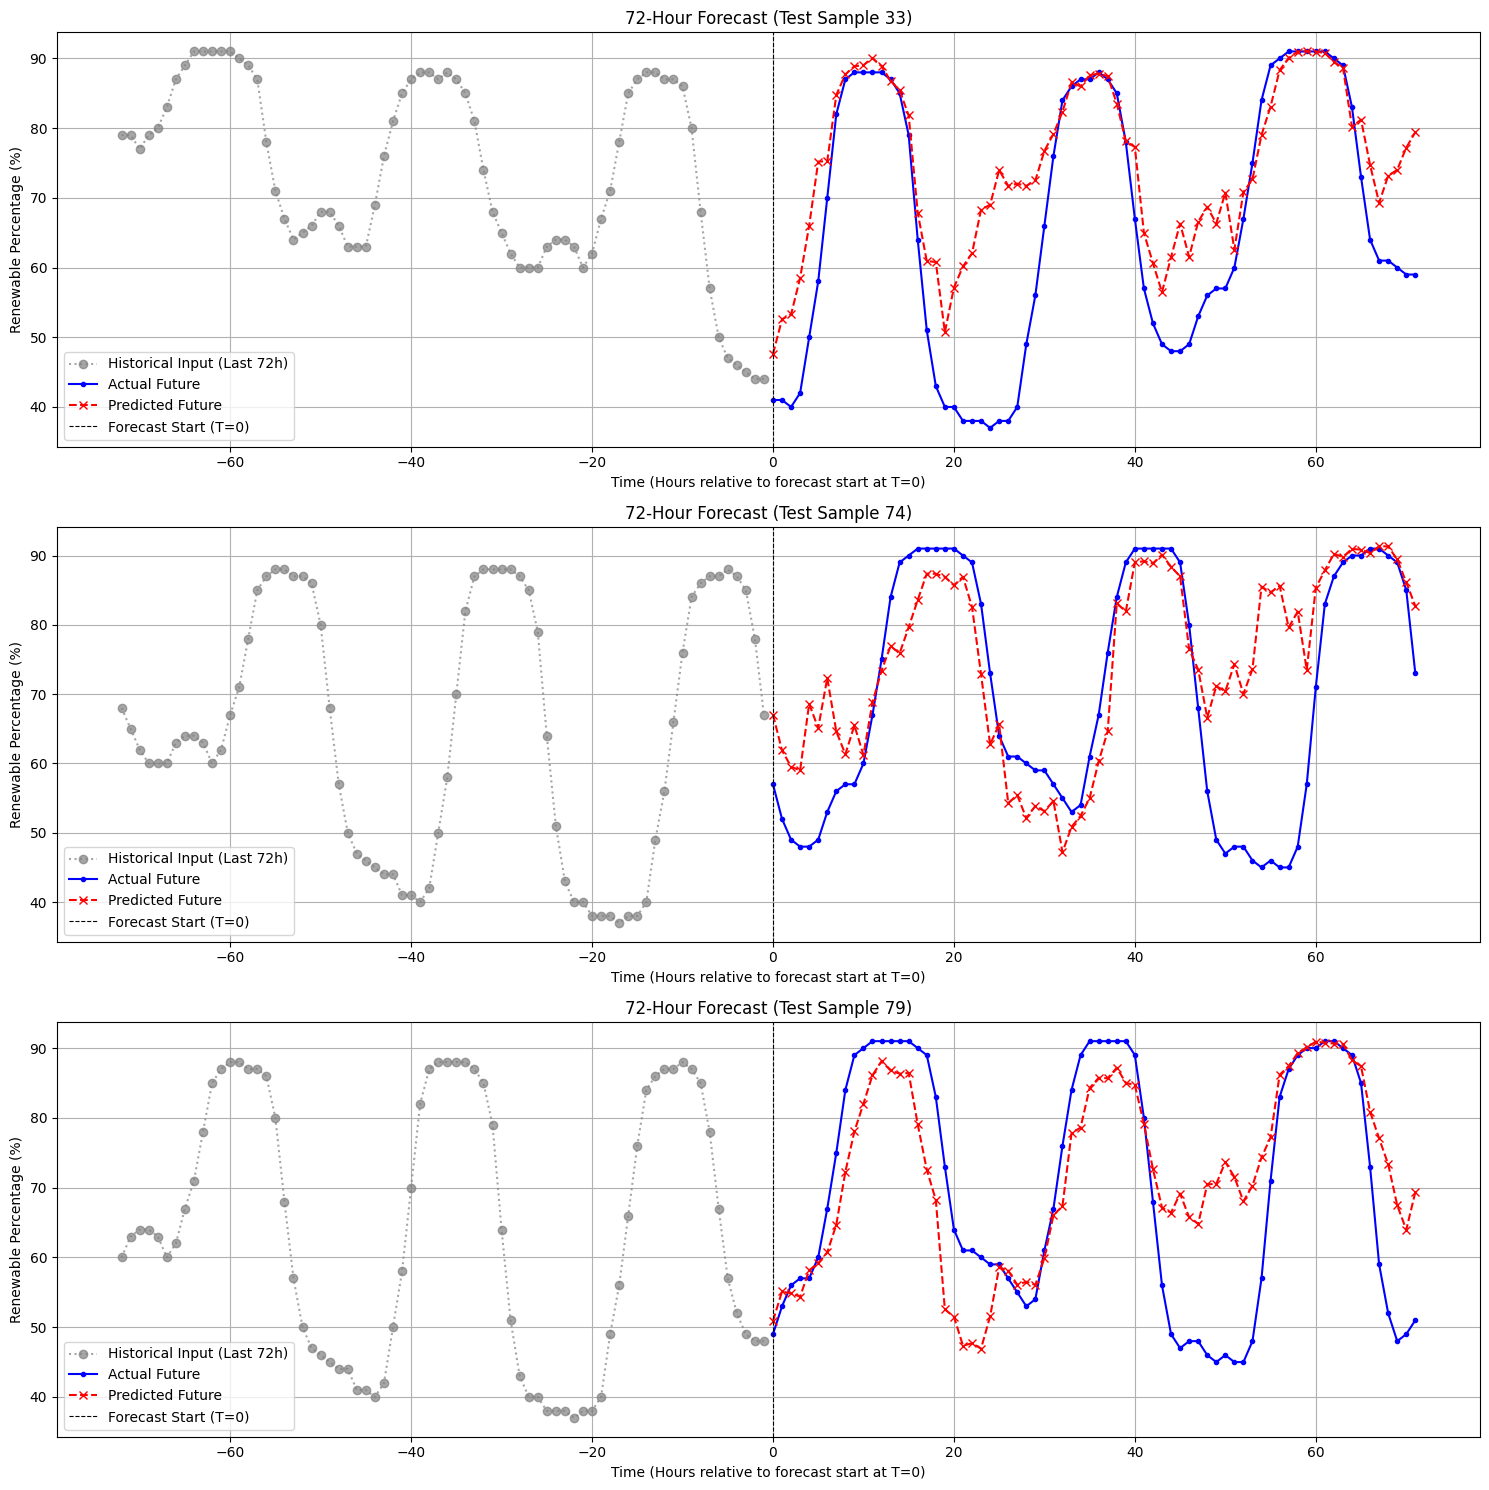

In [10]:
# Cell 8: Final Model Evaluation on Test Set (Corrected)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

if solar_model and X_test.shape[0] > 0 and y_test.shape[0] > 0:
    print("\n--- Final Model Evaluation on Test Set ---")
    # Make predictions on the entire test set
    y_pred_scaled = solar_model.predict(X_test)

    # Flatten the arrays to treat each predicted point independently for metric calculation
    y_test_flat_scaled = y_test.flatten().reshape(-1, 1)
    y_pred_flat_scaled = y_pred_scaled.flatten().reshape(-1, 1)

    y_test_inversed_flat = scaler.inverse_transform(y_test_flat_scaled).flatten()
    y_pred_inversed_flat = scaler.inverse_transform(y_pred_flat_scaled).flatten()

    # Calculate metrics
    mae_overall = mean_absolute_error(y_test_inversed_flat, y_pred_inversed_flat)
    mse_overall = mean_squared_error(y_test_inversed_flat, y_pred_inversed_flat)
    rmse_overall = np.sqrt(mse_overall)

    print(f"\nOverall Test Set Metrics (on inverse-transformed data):")
    print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}")
    print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")

    # Optional: Plot a few examples of predictions vs actuals from the test set
    num_plots = min(3, len(X_test)) # Plot up to 3 examples
    if num_plots > 0:
        plt.figure(figsize=(15, 5 * num_plots))
        for i in range(num_plots):
            sample_idx_plot = np.random.randint(0, len(X_test)) # Pick a random sample
            
            # Get historical input for this sample
            historical_input_scaled_plot = X_test[sample_idx_plot, :, 0]
            historical_input_inversed_plot = scaler.inverse_transform(historical_input_scaled_plot.reshape(-1,1))
            
            # Get true future and predicted future for this sample
            y_true_scaled_plot = y_test[sample_idx_plot]
            y_pred_scaled_plot = y_pred_scaled[sample_idx_plot]
            
            y_true_inversed_plot = scaler.inverse_transform(y_true_scaled_plot.reshape(-1,1))
            y_pred_inversed_plot = scaler.inverse_transform(y_pred_scaled_plot.reshape(-1,1))
            
            time_axis_input_plot = np.arange(-LOOK_BACK, 0)
            time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
            
            plt.subplot(num_plots, 1, i + 1)
            plt.plot(time_axis_input_plot, historical_input_inversed_plot, label=f'Historical Input (Last {LOOK_BACK}h)', marker='o', linestyle=':', color='gray', alpha=0.7)
            plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
            plt.plot(time_axis_output_plot, y_pred_inversed_plot, label='Predicted Future', marker='x', linestyle='--', color='red')
            plt.title(f'{FORECAST_HORIZON}-Hour Forecast (Test Sample {sample_idx_plot})')
            plt.xlabel('Time (Hours relative to forecast start at T=0)')
            plt.ylabel('Renewable Percentage (%)')
            plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
            plt.legend()
            plt.grid(True)
            
        plt.tight_layout()
        plt.show()
    else:
        print("No samples available in the test set to plot.")
else:
    print("Model not trained or no test data available for final evaluation.")

Loading and preparing Winter data from: energy_data_DE_5years_winter.csv
Feature engineering complete.
Datasets created.
X_train shape: (15161, 72, 5), y_train shape: (15161, 72)

--- Starting Transformer Winter Model Training ---

Epoch 1/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 0.2251 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 2/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - loss: 0.1721 - val_loss: 0.1868 - learning_rate: 0.0010
Epoch 3/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.1644 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 4/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.1605 - val_loss: 0.2011 - learning_rate: 0.0010
Epoch 5/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.1587 - val_loss: 0.1957 - learning_rate: 0.0010
Epoch 6/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.1567 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 7/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.1580 - val_loss: 0.1820 -

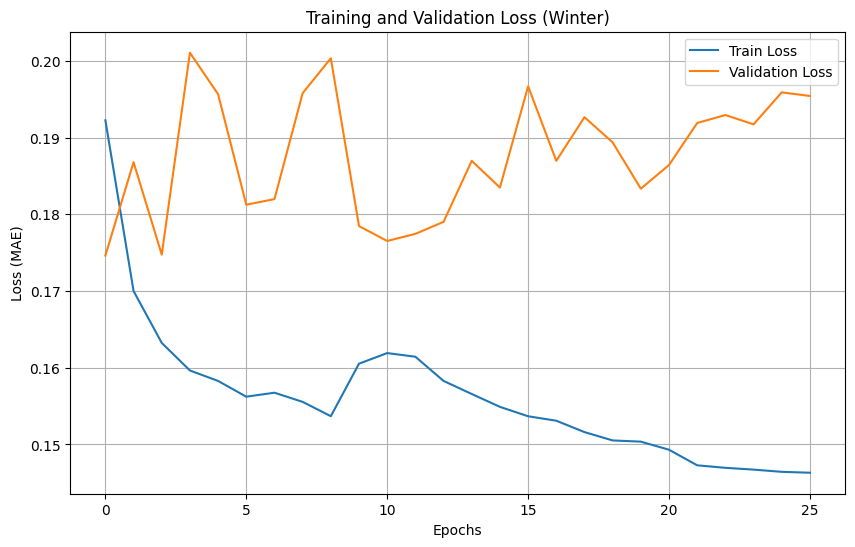

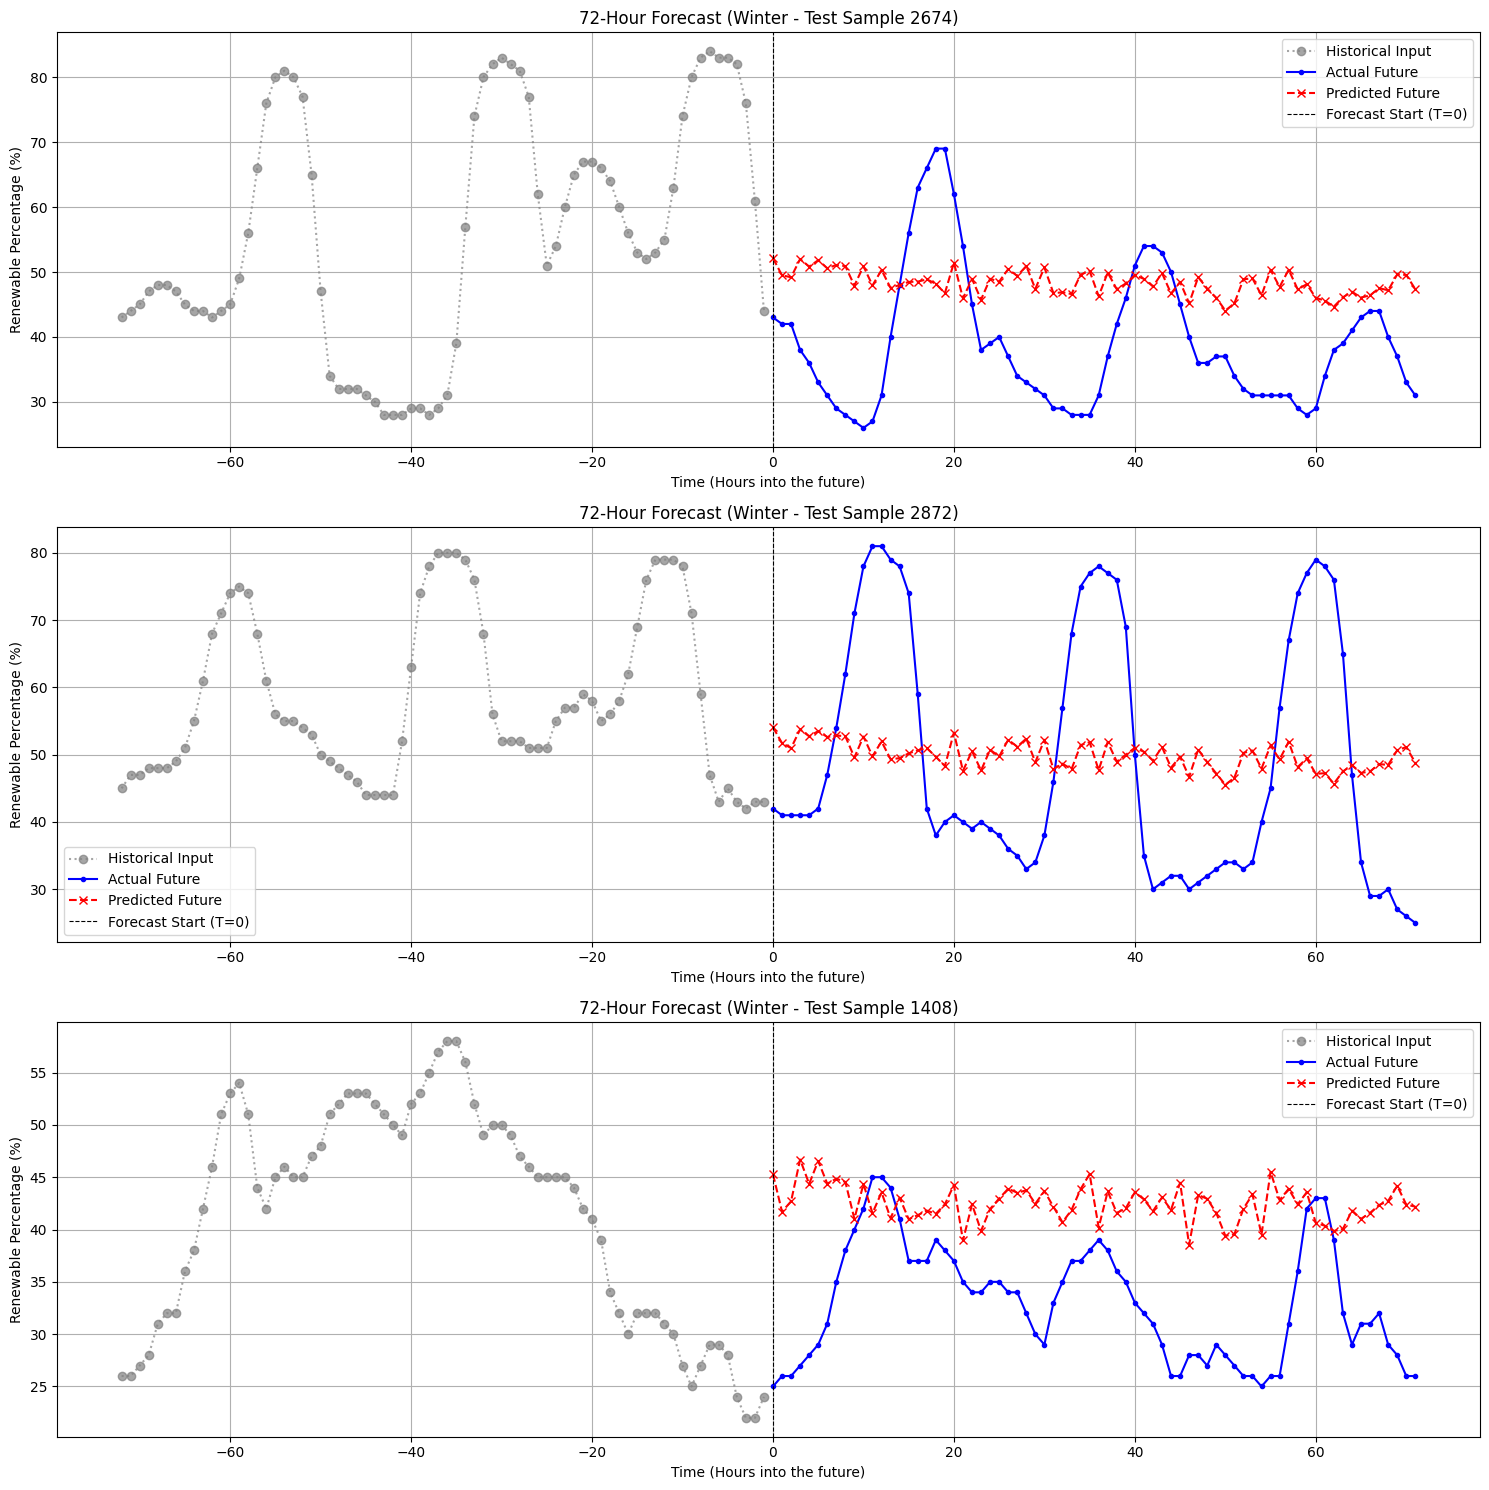

In [6]:
#!/usr/bin/env python
# coding: utf-8

# # 72-Hour Renewable Energy Forecast - V10 with Transformer Model (Corrected)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# --- Configuration ---
config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_col': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,
        'output_length': 72,
        'd_model': 64,         # Dimension of the model
        'num_heads': 4,         # Number of attention heads
        'dff': 128,             # Dimension of the feed-forward network
        'num_encoder_layers': 4,# Number of transformer blocks
        'mlp_units': [128],
        'dropout_rate': 0.2,
        'mlp_dropout': 0.3
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'patience_lr': 10,
        'lr_reduction': 0.1,
        'min_learning_rate': 1e-05,
        'early_stopping_patience': 25
    }
}

# --- Seasonal Parameters (Winter) ---
SEASON = 'Winter'
MONTHS = [10, 11, 12, 1, 2, 3] # October to March
DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years_{SEASON.lower()}.csv"


# --- Data Handling and Feature Engineering ---

def create_time_features(df):
    """Creates time-based features from the DataFrame index."""
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    return df

def cyclical_encode(data, col, max_val):
    """Applies sine and cosine encoding to a column."""
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

def load_and_prepare_data(file_path, target_col):
    """Loads, filters, and engineers features for the seasonal data."""
    print(f"Loading and preparing {SEASON} data from: {file_path}")
    try:
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data = data.rename(columns={data.columns[0]: target_col})
    except FileNotFoundError:
        print(f"CRITICAL: Data file not found at '{os.path.abspath(file_path)}'.")
        return None

    data = create_time_features(data)
    data = cyclical_encode(data, 'hour', 23.0)
    data = cyclical_encode(data, 'day_of_year', 365.0)
    
    feature_cols = [
        target_col,
        'hour_sin', 'hour_cos',
        'day_of_year_sin', 'day_of_year_cos'
    ]
    # Drop original time columns after encoding
    data = data[feature_cols].drop(columns=['hour', 'day_of_year'], errors='ignore')
    
    print("Feature engineering complete.")
    return data

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    return data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]

def fit_scaler(train_data):
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

# FIXED: Corrected function signature
def create_sequences(data_x, data_y, input_length, output_length):
    x_list, y_list = [], []
    for i in range(len(data_x) - input_length - output_length + 1):
        x_list.append(data_x[i : i + input_length, :])
        y_list.append(data_y[i + input_length : i + input_length + output_length])
    return np.array(x_list), np.array(y_list)


# --- Transformer Model Components ---

# FIXED: Corrected TransformerEncoder class
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout=0, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

# --- Transformer Model Builder ---
def build_transformer_model(
    input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # Project input features to the model's embedding dimension (head_size)
    x = layers.Dense(head_size)(x)
    
    # Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = TransformerEncoder(head_size, ff_dim, num_heads, dropout=dropout)(x)
    
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    
    # MLP Head
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    outputs = layers.Dense(config['model_params']['output_length'])(x)
    return keras.Model(inputs, outputs)


# --- Plotting & Evaluation Utility Functions ---
def plot_training_history(history, season):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Training and Validation Loss ({season})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MAE)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"training_loss_plot_{season.lower()}_final.png")

def plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3):
    LOOK_BACK = config['model_params']['input_length']
    FORECAST_HORIZON = config['model_params']['output_length']
    num_features = X_test.shape[2]
    if len(X_test) == 0: return

    num_plots = min(num_plots, len(X_test))
    plt.figure(figsize=(15, 5 * num_plots))
    for i in range(num_plots):
        sample_idx_plot = np.random.randint(0, len(X_test))
        y_pred_scaled_sample = model.predict(X_test[sample_idx_plot:sample_idx_plot+1])
        
        dummy_pred = np.zeros((len(y_pred_scaled_sample[0]), num_features))
        dummy_pred[:, target_col_index] = y_pred_scaled_sample[0, :]
        y_pred_inversed_plot = scaler.inverse_transform(dummy_pred)[:, target_col_index]
        
        dummy_true = np.zeros_like(dummy_pred)
        dummy_true[:, target_col_index] = y_test[sample_idx_plot]
        y_true_inversed_plot = scaler.inverse_transform(dummy_true)[:, target_col_index]

        historical_input_inversed_plot = scaler.inverse_transform(X_test[sample_idx_plot])[:, target_col_index]
        
        time_axis_input_plot = np.arange(-LOOK_BACK, 0)
        time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
        
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(time_axis_input_plot, historical_input_inversed_plot, label='Historical Input', marker='o', linestyle=':', color='gray', alpha=0.7)
        plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
        plt.plot(time_axis_output_plot, y_pred_inversed_plot, label='Predicted Future', marker='x', linestyle='--', color='red')
        plt.title(f'{FORECAST_HORIZON}-Hour Forecast ({SEASON} - Test Sample {sample_idx_plot})')
        plt.xlabel('Time (Hours into the future)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"forecast_examples_{SEASON.lower()}_final.png")


# --- Main Execution ---
if __name__ == "__main__":
    full_feature_data = load_and_prepare_data(DATA_FILENAME, config['data_params']['target_col'])
    if full_feature_data is not None:
        target_col_index = full_feature_data.columns.get_loc(config['data_params']['target_col'])
        train_df, val_df, test_df = train_val_test_split(full_feature_data)
        
        scaler = fit_scaler(train_df)
        train_scaled = scaler.transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        # FIXED: Corrected function call
        X_train, y_train = create_sequences(train_scaled, train_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_val, y_val = create_sequences(val_scaled, val_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_test, y_test = create_sequences(test_scaled, test_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        
        print("Datasets created.")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        
        # FIXED: Corrected dictionary key access
        model = build_transformer_model(
            (X_train.shape[1], X_train.shape[2]),
            head_size=config['model_params']['d_model'],
            num_heads=config['model_params']['num_heads'],
            ff_dim=config['model_params']['dff'],
            num_transformer_blocks=config['model_params']['num_encoder_layers'],
            mlp_units=config['model_params']['mlp_units'],
            dropout=config['model_params']['dropout_rate'],
            mlp_dropout=config['model_params']['mlp_dropout'],
        )
        
        optimizer = keras.optimizers.Adam(learning_rate=config['training_params']['initial_learning_rate'])
        model.compile(optimizer=optimizer, loss='mean_absolute_error')

        callbacks = [
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=config['training_params']['lr_reduction'], patience=config['training_params']['patience_lr'], min_lr=config['training_params']['min_learning_rate']),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['training_params']['early_stopping_patience'], restore_best_weights=True)
        ]
        
        print(f"\n--- Starting Transformer {SEASON} Model Training ---\n")
        history = model.fit(X_train, y_train,
                            epochs=config['training_params']['num_epochs'],
                            batch_size=config['training_params']['batch_size'],
                            validation_data=(X_val, y_val),
                            callbacks=callbacks,
                            verbose=1)
        
        plot_training_history(history, SEASON)
        
        if X_test.shape[0] > 0 and y_test.shape[0] > 0:
            print(f"\n--- Final Model Evaluation on {SEASON} Test Set ---")
            y_pred_scaled = model.predict(X_test)
            
            num_test_samples = y_test.shape[0] * y_test.shape[1]
            num_features = X_test.shape[2]
            
            y_test_dummy = np.zeros((num_test_samples, num_features)); y_test_dummy[:, target_col_index] = y_test.flatten()
            y_test_inversed = scaler.inverse_transform(y_test_dummy)[:, target_col_index]
            y_pred_dummy = np.zeros((num_test_samples, num_features)); y_pred_dummy[:, target_col_index] = y_pred_scaled.flatten()
            y_pred_inversed = scaler.inverse_transform(y_pred_dummy)[:, target_col_index]
            
            mae_overall = mean_absolute_error(y_test_inversed, y_pred_inversed)
            mse_overall = mean_squared_error(y_test_inversed, y_pred_inversed)
            rmse_overall = np.sqrt(mse_overall)
            
            print(f"\nOverall Test Set Metrics ({SEASON}):"); print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}"); print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}"); print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")
            
            plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3)
        
    else:
        print("Data could not be loaded. Halting execution.")


# Transfoemer Model


Loading and preparing Winter data from: energy_data_DE_5years_winter.csv
Generating simulated weather data...
Feature engineering complete.
TensorFlow Datasets created.
X_train shape: (15161, 72, 7), y_train shape: (15161, 72)

--- Starting Quantile CycleLSTM Winter Model Training ---

Epoch 1/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0736 - val_loss: 0.0586
Epoch 2/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0548 - val_loss: 0.0558
Epoch 3/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0538 - val_loss: 0.0552
Epoch 4/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0537 - val_loss: 0.0550
Epoch 5/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0537 - val_loss: 0.0548
Epoch 6/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0536 - val_loss: 0.0549
Epoch 7/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0537 - val_loss: 0.0548
Epoch 8/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0535 - val_loss: 0.0547
Epoch 9/

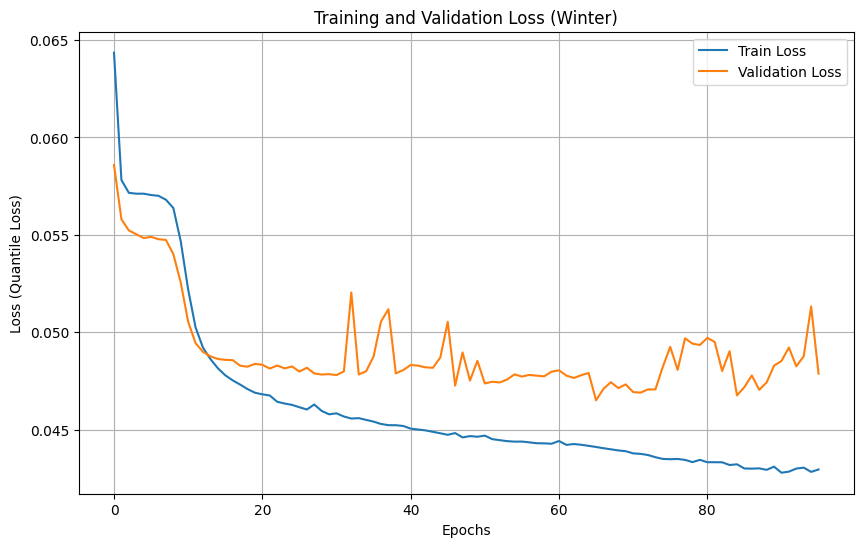

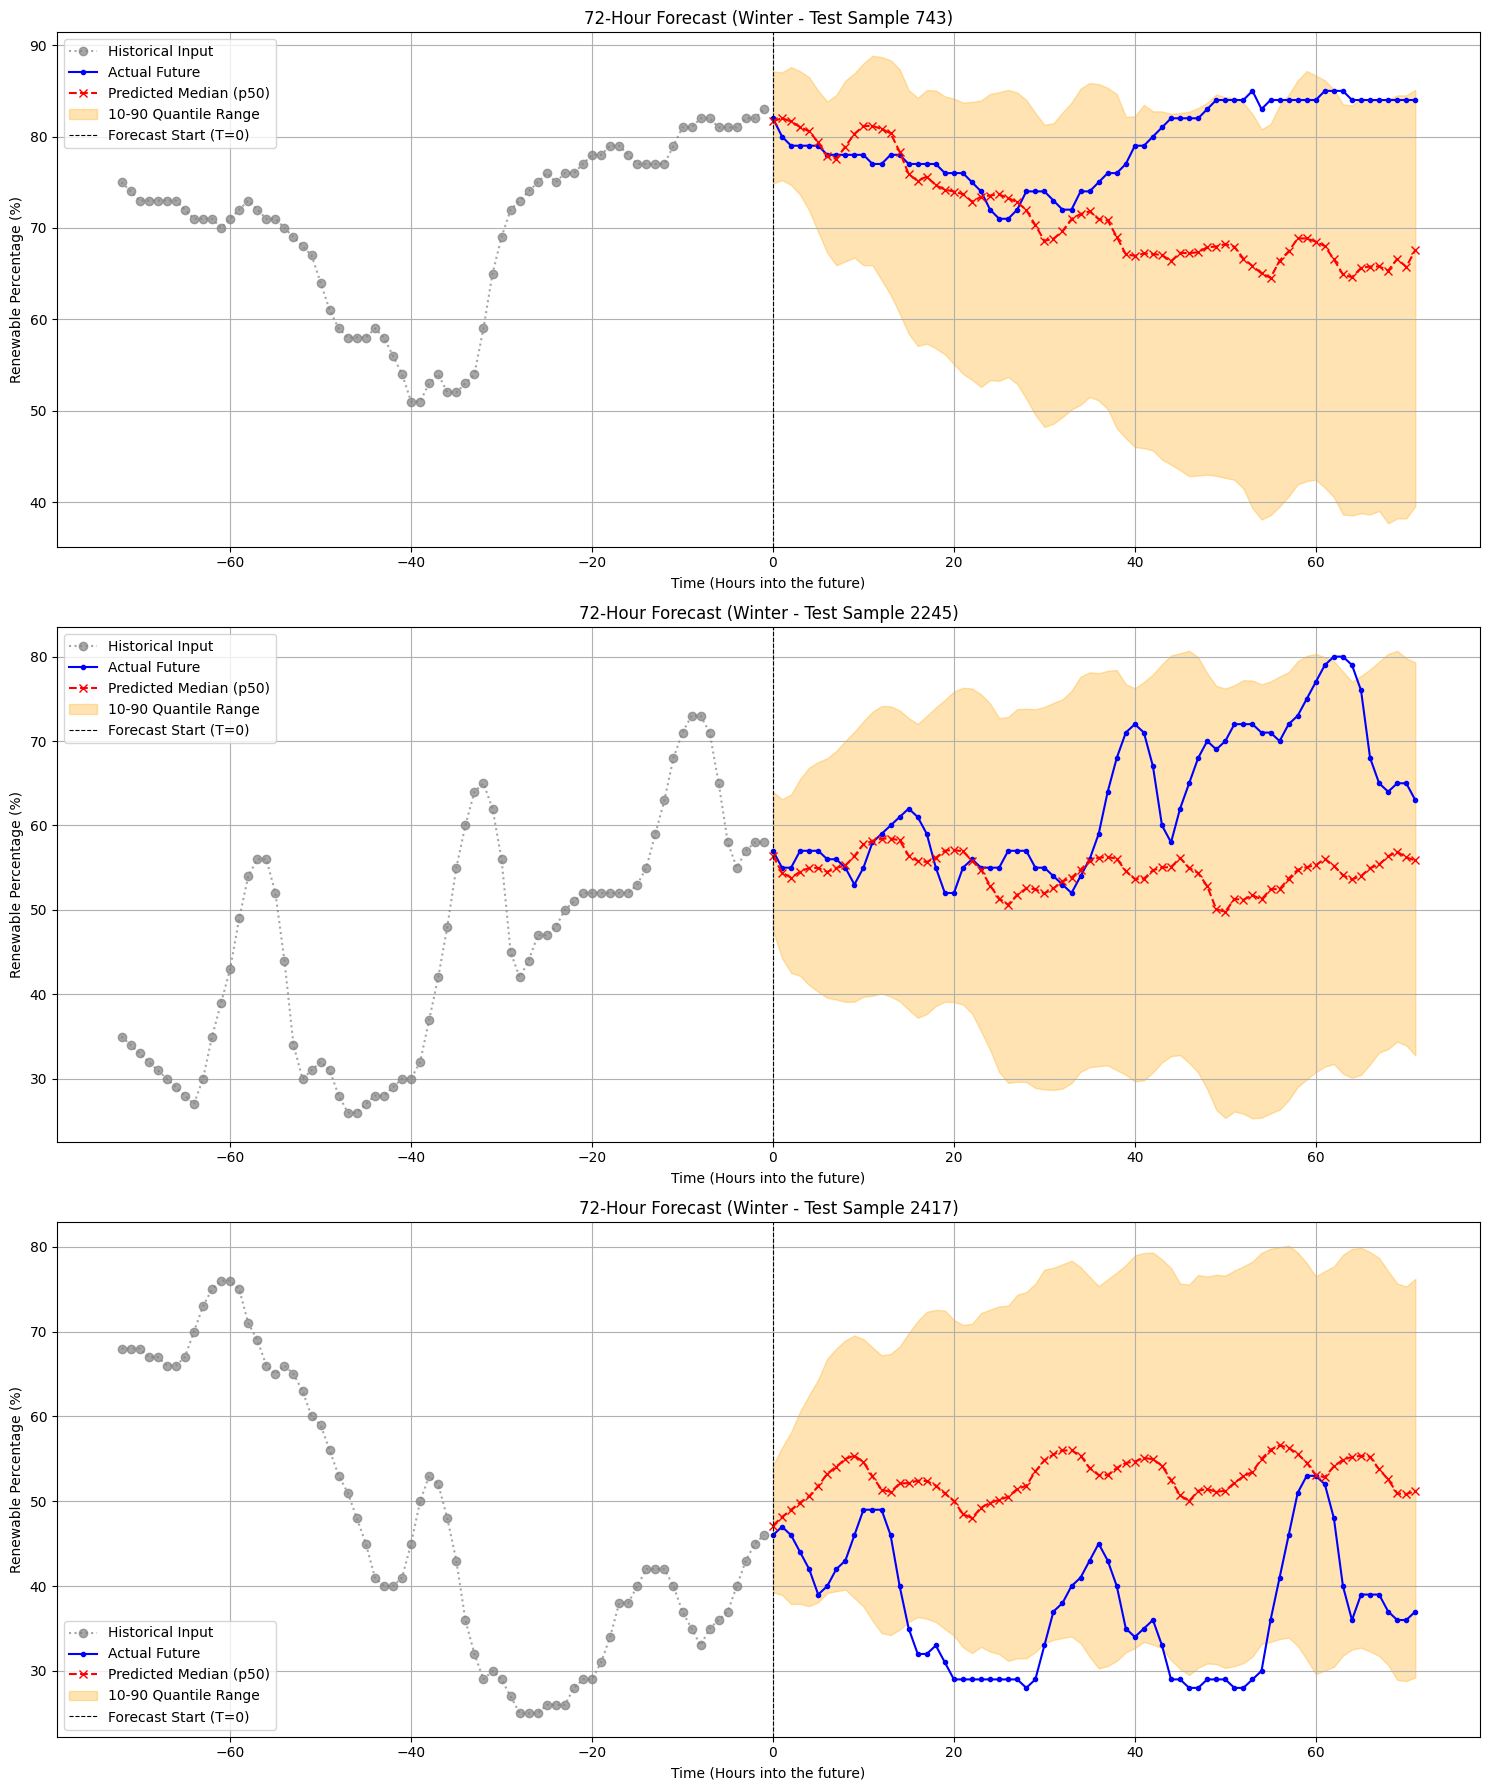

In [14]:
#!/usr/bin/env python
# coding: utf-8

# # 72-Hour Renewable Energy Forecast (CycleLSTM) - Final Version with Quantile Regression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# --- Configuration ---
config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_col': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,
        'output_length': 72,
        'hidden_size': 96,
        'dropout': 0.3,
        'cycle_len': 24,
        'l2_reg': 0.001,
        'quantiles': [0.1, 0.5, 0.9] # ADDED: Define the quantiles to predict
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'early_stopping_patience': 30
    }
}

# --- Seasonal Parameters (Winter) ---
SEASON = 'Winter'
MONTHS = [10, 11, 12, 1, 2, 3] # October to March
DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years_{SEASON.lower()}.csv"


# --- Data Handling and Feature Engineering ---

def create_time_features(df):
    """Creates time-based features from the DataFrame index."""
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    return df

def cyclical_encode(data, col, max_val):
    """Applies sine and cosine encoding to a column."""
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

def generate_simulated_weather(df_index):
    """Generates plausible, simulated weather data."""
    print("Generating simulated weather data...")
    day_of_year = df_index.dayofyear
    hour = df_index.hour
    temp_seasonal_cycle = -np.cos(2 * np.pi * (day_of_year - 45) / 365.25)
    temp_daily_cycle = -np.cos(2 * np.pi * hour / 24)
    temperature = 5 + (temp_seasonal_cycle * 12) + (temp_daily_cycle * 6) + np.random.normal(0, 3, len(df_index))
    cloud_seasonal_cycle = np.cos(2 * np.pi * (day_of_year - 45) / 365.25)
    cloud_cover = 55 + (cloud_seasonal_cycle * 25) + np.random.normal(0, 15, len(df_index))
    cloud_cover = np.clip(cloud_cover, 0, 100)
    weather_df = pd.DataFrame(index=df_index, data={'temperature': temperature, 'cloud_cover': cloud_cover})
    return weather_df

def load_and_prepare_data(file_path, target_col):
    """Loads, filters, adds features, and merges weather data."""
    print(f"Loading and preparing {SEASON} data from: {file_path}")
    try:
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data = data.rename(columns={data.columns[0]: target_col})
    except FileNotFoundError:
        print(f"CRITICAL: Data file not found at '{os.path.abspath(file_path)}'.")
        return None

    data = create_time_features(data)
    data = cyclical_encode(data, 'hour', 23.0)
    data = cyclical_encode(data, 'day_of_year', 365.0)
    weather_data = generate_simulated_weather(data.index)
    data = data.join(weather_data)
    
    feature_cols = [
        target_col, 'temperature', 'cloud_cover',
        'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos'
    ]
    data = data[feature_cols].dropna()
    print("Feature engineering complete.")
    return data

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    return data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]

def fit_scaler(train_data):
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

def create_multivariate_sequences(data_x, data_y, input_length, output_length, cycle_len):
    x_list, y_list, cycle_idx_list = [], [], []
    cycle_indices = (np.arange(len(data_x)) % cycle_len).reshape(-1, 1)
    for i in range(len(data_x) - input_length - output_length + 1):
        x_list.append(data_x[i : i + input_length, :])
        y_list.append(data_y[i + input_length : i + input_length + output_length])
        cycle_idx_list.append(cycle_indices[i])
    return np.array(x_list), np.array(y_list), np.array(cycle_idx_list, dtype=np.int32)


# --- Custom Keras Layers & Loss Function ---
class RecurrentCycle(layers.Layer):
    def __init__(self, cycle_len, channel_size, **kwargs):
        super(RecurrentCycle, self).__init__(**kwargs)
        self.cycle_len = cycle_len
        self.channel_size = channel_size
    def build(self, input_shape):
        self.data = self.add_weight(shape=(self.cycle_len, self.channel_size), initializer="zeros", trainable=True, name="cycle_memory")
        super().build(input_shape)
    def call(self, index, length=None):
        if length is None: raise ValueError("The 'length' argument must be provided.")
        idx_flat = tf.reshape(index, [-1, 1])
        range_tensor = tf.range(length, dtype=tf.int32)
        range_tensor = tf.reshape(range_tensor, [1, -1])
        gather_index = (idx_flat + range_tensor) % self.cycle_len
        return tf.gather(self.data, gather_index)

class Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)
    def call(self, x):
        et = keras.backend.squeeze(keras.backend.tanh(keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = keras.backend.softmax(et)
        at = keras.backend.expand_dims(at, axis=-1)
        output = x * at
        return keras.backend.sum(output, axis=1)

# FIXED: Quantile Loss (Pinball Loss)
class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, quantiles):
        super().__init__()
        # Convert the list of quantiles to a TensorFlow constant
        self.quantiles = tf.constant(quantiles, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        y_true = tf.expand_dims(y_true, axis=-1)

        error = y_true - y_pred
        # Now the math operations will work correctly on the tensor
        loss = tf.reduce_mean(tf.maximum(self.quantiles * error, (self.quantiles - 1) * error), axis=-1)
        return loss

# --- CycleLSTM Keras Model for Quantile Regression ---
class CycleLSTMModel(keras.Model):
    def __init__(self, hidden_size, output_size, cycle_len, num_features, seq_len, dropout=0.2, l2_reg=0.001, quantiles=None, **kwargs):
        super(CycleLSTMModel, self).__init__(**kwargs)
        self.output_size = output_size
        self.seq_len = seq_len
        self.cycle_len = cycle_len 
        self.quantiles = quantiles if quantiles is not None else [0.5]
        self.num_quantiles = len(self.quantiles)
        
        self.cycle_queue = RecurrentCycle(cycle_len=cycle_len, channel_size=num_features)
        self.lstm_layer = layers.LSTM(hidden_size, return_sequences=True, dropout=dropout, kernel_regularizer=keras.regularizers.l2(l2_reg))
        self.attention = Attention()
        self.fc = layers.Dense(output_size * self.num_quantiles)

    def call(self, inputs):
        x, index = inputs
        cq = self.cycle_queue(index, length=self.seq_len)
        x = x - cq
        lstm_out = self.lstm_layer(x)
        att_out = self.attention(lstm_out)
        out = self.fc(att_out)
        
        out = tf.reshape(out, (-1, self.output_size, self.num_quantiles))
        
        future_index = (index + self.seq_len) % self.cycle_len
        cp = self.cycle_queue(future_index, length=self.output_size)
        
        cp_reshaped = tf.expand_dims(cp[:, :, 0], axis=-1)
        
        out = out + cp_reshaped
        return out

# --- Plotting & Evaluation Utility Functions ---
def plot_training_history(history, season):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Training and Validation Loss ({season})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Quantile Loss)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"training_loss_plot_{season.lower()}_quantile.png")

def plot_test_forecasts(model, X_test, y_test, cycle_test, scaler, target_col_index, num_plots=3):
    LOOK_BACK = config['model_params']['input_length']
    FORECAST_HORIZON = config['model_params']['output_length']
    if len(X_test) == 0: return

    num_plots = min(num_plots, len(X_test))
    plt.figure(figsize=(15, 6 * num_plots))
    for i in range(num_plots):
        sample_idx_plot = np.random.randint(0, len(X_test))
        y_pred_scaled_sample = model.predict((X_test[sample_idx_plot:sample_idx_plot+1], cycle_test[sample_idx_plot:sample_idx_plot+1]))[0]
        
        y_pred_inversed_quantiles = []
        for j in range(y_pred_scaled_sample.shape[1]):
            dummy_pred = np.zeros((FORECAST_HORIZON, X_test.shape[2]))
            dummy_pred[:, target_col_index] = y_pred_scaled_sample[:, j]
            y_pred_inversed_plot = scaler.inverse_transform(dummy_pred)[:, target_col_index]
            y_pred_inversed_quantiles.append(y_pred_inversed_plot)
        
        dummy_true = np.zeros((FORECAST_HORIZON, X_test.shape[2]))
        dummy_true[:, target_col_index] = y_test[sample_idx_plot]
        y_true_inversed_plot = scaler.inverse_transform(dummy_true)[:, target_col_index]

        historical_input_inversed_plot = scaler.inverse_transform(X_test[sample_idx_plot])[:, target_col_index]
        
        time_axis_input_plot = np.arange(-LOOK_BACK, 0)
        time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
        
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(time_axis_input_plot, historical_input_inversed_plot, label='Historical Input', marker='o', linestyle=':', color='gray', alpha=0.7)
        plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
        plt.plot(time_axis_output_plot, y_pred_inversed_quantiles[1], label='Predicted Median (p50)', marker='x', linestyle='--', color='red')
        plt.fill_between(time_axis_output_plot, y_pred_inversed_quantiles[0], y_pred_inversed_quantiles[2], color='orange', alpha=0.3, label='10-90 Quantile Range')
        
        plt.title(f'{FORECAST_HORIZON}-Hour Forecast ({SEASON} - Test Sample {sample_idx_plot})')
        plt.xlabel('Time (Hours into the future)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"forecast_examples_{SEASON.lower()}_quantile.png")


# --- Main Execution ---
if __name__ == "__main__":
    full_feature_data = load_and_prepare_data(DATA_FILENAME, config['data_params']['target_col'])
    if full_feature_data is not None:
        target_col_index = full_feature_data.columns.get_loc(config['data_params']['target_col'])
        train_df, val_df, test_df = train_val_test_split(full_feature_data)
        
        scaler = fit_scaler(train_df)
        train_scaled = scaler.transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        X_train, y_train, cycle_train = create_multivariate_sequences(train_scaled, train_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])
        X_val, y_val, cycle_val = create_multivariate_sequences(val_scaled, val_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])
        X_test, y_test, cycle_test = create_multivariate_sequences(test_scaled, test_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])

        train_ds = tf.data.Dataset.from_tensor_slices(((X_train, cycle_train), y_train)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)
        val_ds = tf.data.Dataset.from_tensor_slices(((X_val, cycle_val), y_val)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)
        
        print("TensorFlow Datasets created.")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        
        model = CycleLSTMModel(
            hidden_size=config['model_params']['hidden_size'],
            output_size=config['model_params']['output_length'],
            cycle_len=config['model_params']['cycle_len'],
            num_features=X_train.shape[2],
            seq_len=config['model_params']['input_length'],
            dropout=config['model_params']['dropout'],
            l2_reg=config['model_params']['l2_reg'],
            quantiles=config['model_params']['quantiles']
        )
        
        optimizer = tf.keras.optimizers.AdamW(learning_rate=config['training_params']['initial_learning_rate'], weight_decay=0.01)
        
        model.compile(optimizer=optimizer, loss=QuantileLoss(config['model_params']['quantiles']))

        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['training_params']['early_stopping_patience'], restore_best_weights=True)
        ]
        
        print(f"\n--- Starting Quantile CycleLSTM {SEASON} Model Training ---\n")
        history = model.fit(train_ds, epochs=config['training_params']['num_epochs'], validation_data=val_ds, callbacks=callbacks, verbose=1)
        
        plot_training_history(history, SEASON)
        
        if X_test.shape[0] > 0 and y_test.shape[0] > 0:
            print(f"\n--- Final Model Evaluation on {SEASON} Test Set ---")
            y_pred_scaled = model.predict((X_test, cycle_test))
            
            # Evaluate based on the median (50th percentile) prediction
            median_pred_scaled = y_pred_scaled[:, :, 1]
            
            num_test_samples = y_test.shape[0] * y_test.shape[1]
            num_features = X_test.shape[2]
            
            y_test_dummy = np.zeros((num_test_samples, num_features)); y_test_dummy[:, target_col_index] = y_test.flatten()
            y_test_inversed = scaler.inverse_transform(y_test_dummy)[:, target_col_index]
            
            y_pred_dummy = np.zeros((num_test_samples, num_features)); y_pred_dummy[:, target_col_index] = median_pred_scaled.flatten()
            y_pred_inversed = scaler.inverse_transform(y_pred_dummy)[:, target_col_index]
            
            mae_overall = mean_absolute_error(y_test_inversed, y_pred_inversed)
            mse_overall = mean_squared_error(y_test_inversed, y_pred_inversed)
            rmse_overall = np.sqrt(mse_overall)
            
            print(f"\nOverall Test Set Metrics ({SEASON} - Median Forecast):"); print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}"); print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}"); print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")
            
            plot_test_forecasts(model, X_test, y_test, cycle_test, scaler, target_col_index, num_plots=3)
        
    else:
        print("Data could not be loaded. Halting execution.")


# N-BEATS Model

Loading and preparing Winter data from: energy_data_DE_5years_winter.csv
Feature engineering complete.
Datasets created.
X_train shape: (15161, 72, 5), y_train shape: (15161, 72)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ stack_input (InputLayer)      │ (None, 72, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_5 (Reshape)           │ (None, 360)               │               0 │ stack_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_3 (Lambda)             │ (None, 216)               │               0 │ reshape_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ n_beats_block_3 (NBeatsBlock) │ [(None, 360), (None,      │         437,824 │ reshape_5[0][0]            │
│                               │ 216)]                     │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 216)               │               0 │ lambda_3[0][0],            │
│                               │                           │                 │ n_beats_block_3[0][1]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_6 (Reshape)           │ (None, 72, 3)             │               0 │ add_3[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 437,824 (1.67 MB)

 Trainable params: 437,824 (1.67 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting N-BEATS Quantile Winter Model Training ---

Epoch 1/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0652 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 2/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0474 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 3/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0462 - val_loss: 0.0474 - learning_rate: 0.0010
Epoch 4/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0456 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 5/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0455 - val_loss: 0.0503 - learning_rate: 0.0010
Epoch 6/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0450 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 7/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0448 - val_loss: 0.0503 - learning_rate: 0.0010
Epoch 8/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0445 - val_loss: 0.0466 - learning_rate: 0.0010
Epoch 9/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

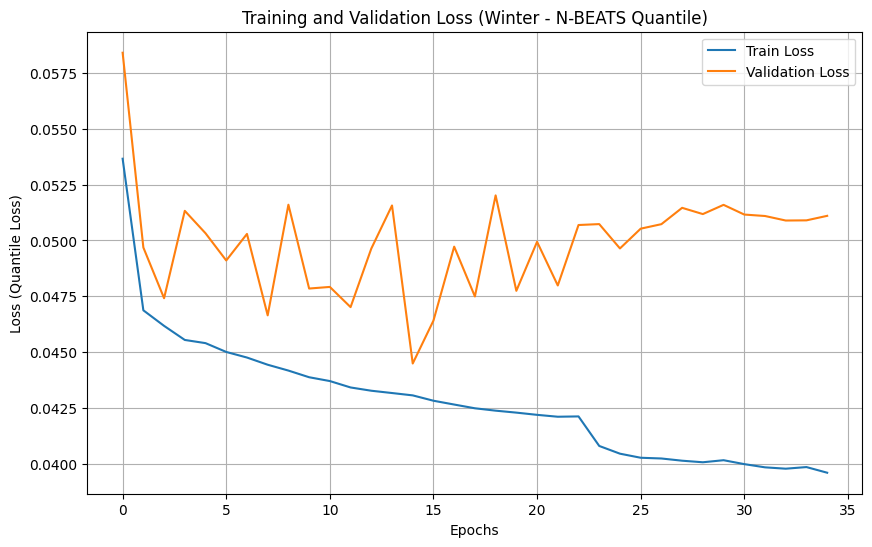

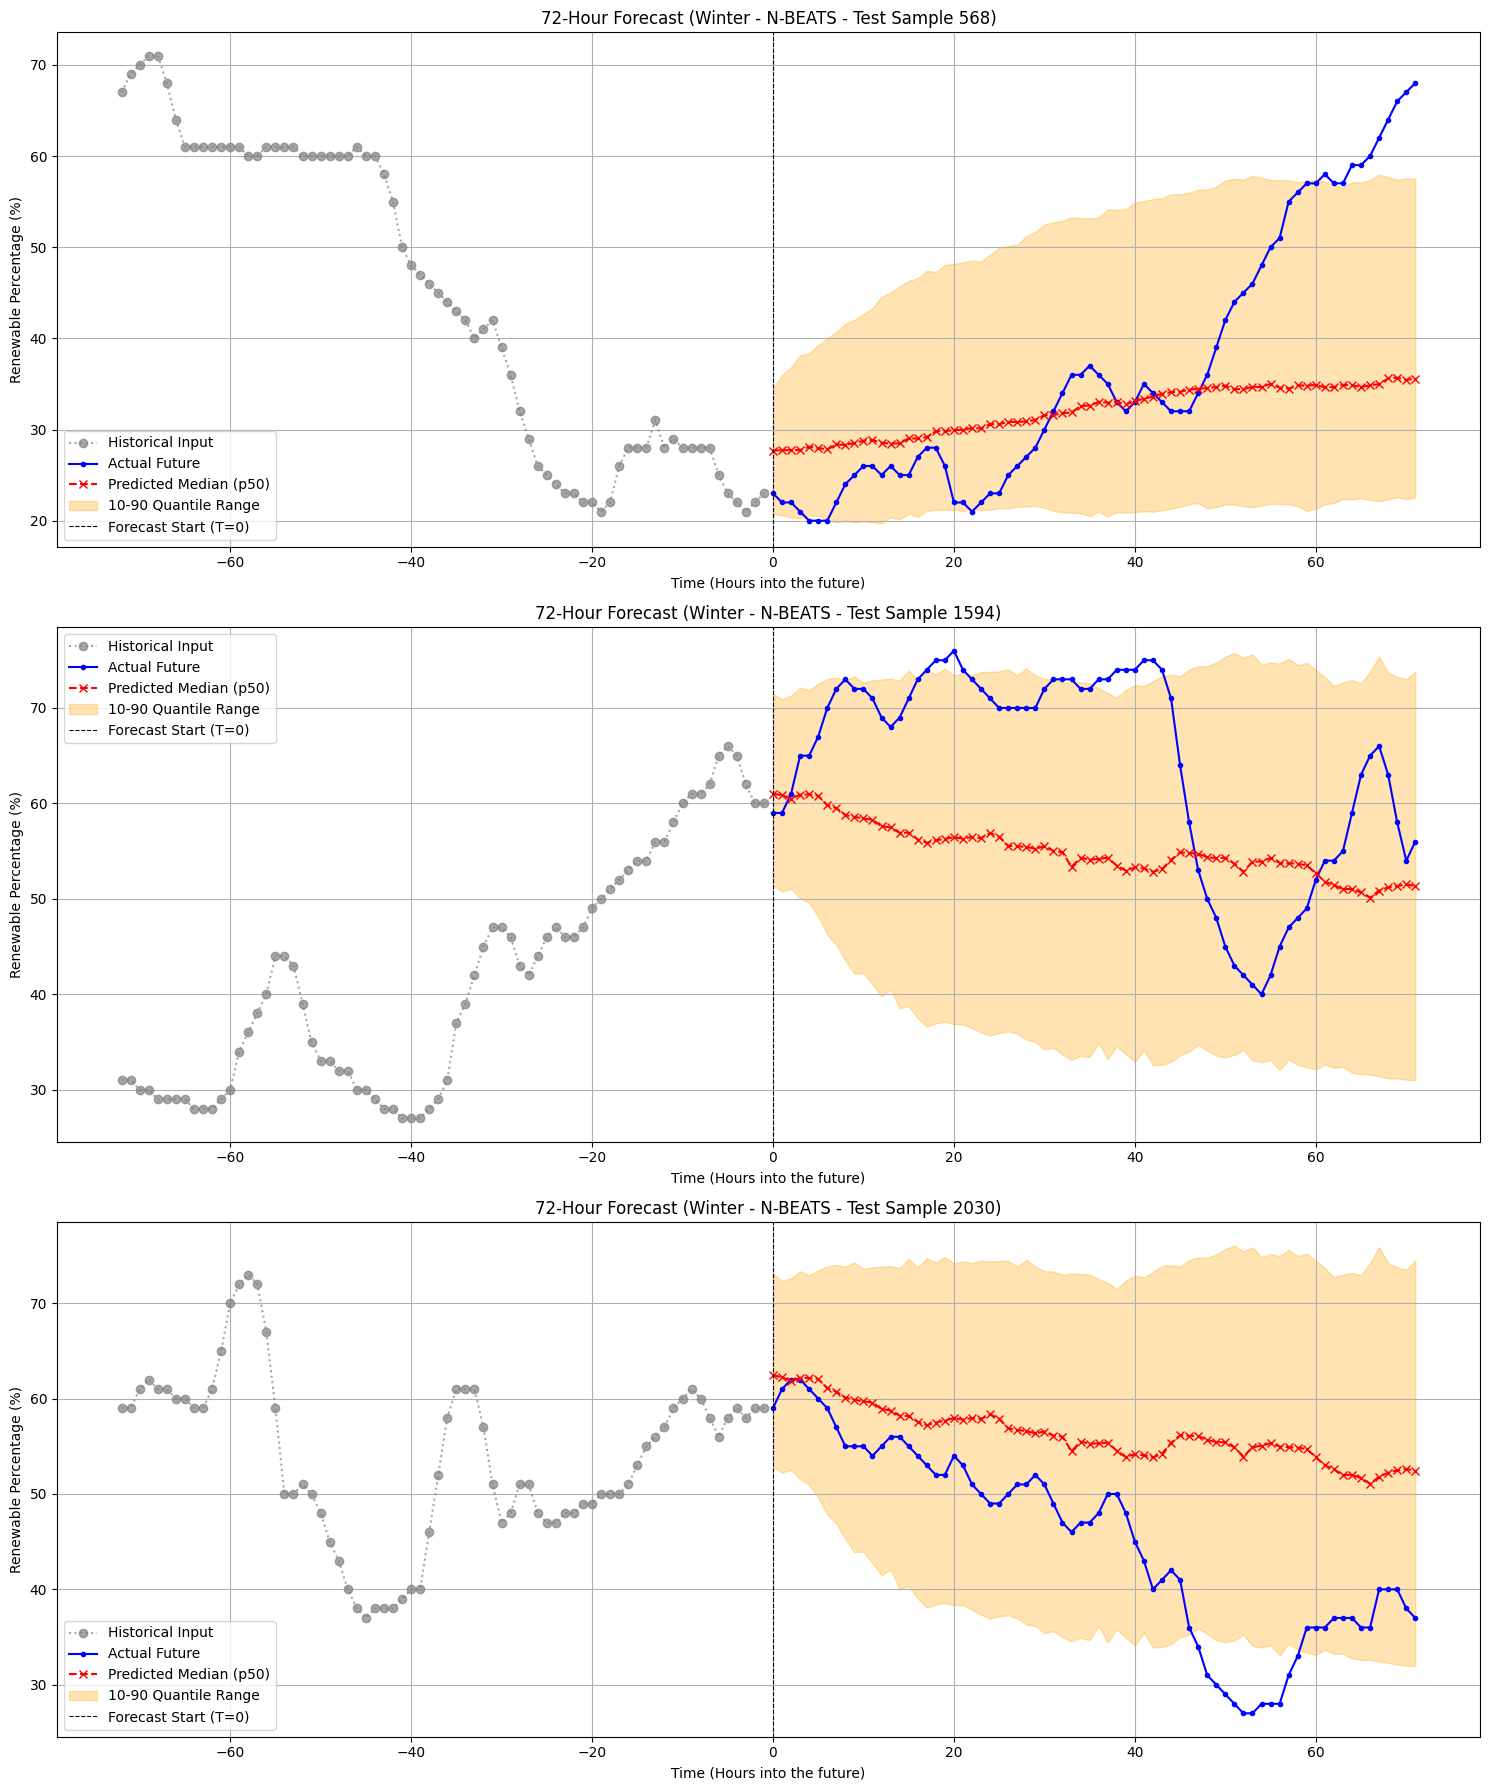

In [6]:
#!/usr/bin/env python
# coding: utf-8

# # 72-Hour Renewable Energy Forecast - N-BEATS with Quantile Regression and Dropout

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# --- Configuration ---
config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_col': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,
        'output_length': 72,
        'n_features': 5,
        'quantiles': [0.1, 0.5, 0.9]
    },
    'nbeats_params': {
        'n_neurons': 256,       # CHANGED: Reduced neurons to decrease complexity
        'n_blocks': 1,
        'n_layers': 4,
        'dropout_rate': 0.2     # ADDED: Dropout for regularization
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'patience_lr': 8,      # Adjusted patience
        'lr_reduction': 0.1,
        'min_learning_rate': 1e-05,
        'early_stopping_patience': 20 # Adjusted patience
    }
}

# --- Seasonal Parameters (Winter) ---
SEASON = 'Winter'
MONTHS = [10, 11, 12, 1, 2, 3] # October to March
DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years_{SEASON.lower()}.csv"


# --- Data Handling and Feature Engineering ---

def create_time_features(df):
    """Creates time-based features from the DataFrame index."""
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    return df

def cyclical_encode(data, col, max_val):
    """Applies sine and cosine encoding to a column."""
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

def load_and_prepare_data(file_path, target_col):
    """Loads, filters, and engineers features for the seasonal data."""
    print(f"Loading and preparing {SEASON} data from: {file_path}")
    try:
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data = data.rename(columns={data.columns[0]: target_col})
    except FileNotFoundError:
        print(f"CRITICAL: Data file not found at '{os.path.abspath(file_path)}'.")
        return None

    data = create_time_features(data)
    data = cyclical_encode(data, 'hour', 23.0)
    data = cyclical_encode(data, 'day_of_year', 365.0)
    
    feature_cols = [
        target_col,
        'hour_sin', 'hour_cos',
        'day_of_year_sin', 'day_of_year_cos'
    ]
    data = data[feature_cols].drop(columns=['hour', 'day_of_year'], errors='ignore')
    
    print("Feature engineering complete.")
    return data

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    return data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]

def fit_scaler(train_data):
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

def create_sequences(data_x, data_y, input_length, output_length):
    x_list, y_list = [], []
    for i in range(len(data_x) - input_length - output_length + 1):
        x_list.append(data_x[i : i + input_length, :])
        y_list.append(data_y[i + input_length : i + input_length + output_length])
    return np.array(x_list), np.array(y_list)


# --- N-BEATS Model Components with Quantile Loss ---

class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = tf.constant(quantiles, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        y_true = tf.expand_dims(y_true, axis=-1)

        error = y_true - y_pred
        loss = tf.reduce_mean(tf.maximum(self.quantiles * error, (self.quantiles - 1) * error), axis=-1)
        return loss

class NBeatsBlock(layers.Layer):
    def __init__(self, input_size, theta_size, n_neurons, n_layers, dropout_rate, **kwargs):
        super(NBeatsBlock, self).__init__(**kwargs)
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.theta_size = theta_size
        self.input_size = input_size
        self.hidden = []
        for _ in range(n_layers):
            self.hidden.append(layers.Dense(n_neurons, activation='relu'))
            # ADDED: Dropout layer in the block
            self.hidden.append(layers.Dropout(dropout_rate))
            
        self.theta_layer = layers.Dense(input_size + theta_size, activation='linear')

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        
        backcast = theta[:, :self.input_size]
        forecast = theta[:, -self.theta_size:]
        
        return inputs - backcast, forecast

def build_nbeats_model(input_length, output_length, n_features, n_neurons, n_blocks, n_layers, dropout_rate, num_quantiles):
    """Builds the N-BEATS model for quantile regression."""
    stack_input = layers.Input(shape=(input_length, n_features), name='stack_input')
    
    reshaped_input = layers.Reshape((input_length * n_features,))(stack_input)
    
    theta_size = output_length * num_quantiles
    
    backcast, forecast = reshaped_input, layers.Lambda(lambda x: tf.zeros([tf.shape(x)[0], theta_size]))(reshaped_input)
    
    for i in range(n_blocks):
        with tf.name_scope(f"NBeatsBlock_{i}"):
            backcast, block_forecast = NBeatsBlock(
                input_size=input_length * n_features,
                theta_size=theta_size,
                n_neurons=n_neurons,
                n_layers=n_layers,
                dropout_rate=dropout_rate
            )(backcast)
            forecast = layers.add([forecast, block_forecast])
            
    final_output = layers.Reshape((output_length, num_quantiles))(forecast)
            
    model = keras.Model(inputs=stack_input, outputs=final_output)
    return model


# --- Plotting & Evaluation Utility Functions ---
def plot_training_history(history, season):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Training and Validation Loss ({season} - N-BEATS Quantile)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Quantile Loss)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"training_loss_plot_{season.lower()}_nbeats_quantile_v2.png")

def plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3):
    LOOK_BACK = config['model_params']['input_length']
    FORECAST_HORIZON = config['model_params']['output_length']
    num_features = X_test.shape[2]
    if len(X_test) == 0: return

    num_plots = min(num_plots, len(X_test))
    plt.figure(figsize=(15, 6 * num_plots))
    for i in range(num_plots):
        sample_idx_plot = np.random.randint(0, len(X_test))
        y_pred_scaled_sample = model.predict(X_test[sample_idx_plot:sample_idx_plot+1])[0]
        
        y_pred_inversed_quantiles = []
        for j in range(y_pred_scaled_sample.shape[1]):
            dummy_pred = np.zeros((FORECAST_HORIZON, num_features))
            dummy_pred[:, target_col_index] = y_pred_scaled_sample[:, j]
            y_pred_inversed_plot = scaler.inverse_transform(dummy_pred)[:, target_col_index]
            y_pred_inversed_quantiles.append(y_pred_inversed_plot)
        
        dummy_true = np.zeros((FORECAST_HORIZON, num_features))
        dummy_true[:, target_col_index] = y_test[sample_idx_plot]
        y_true_inversed_plot = scaler.inverse_transform(dummy_true)[:, target_col_index]

        historical_input_inversed_plot = scaler.inverse_transform(X_test[sample_idx_plot])[:, target_col_index]
        
        time_axis_input_plot = np.arange(-LOOK_BACK, 0)
        time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
        
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(time_axis_input_plot, historical_input_inversed_plot, label='Historical Input', marker='o', linestyle=':', color='gray', alpha=0.7)
        plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
        plt.plot(time_axis_output_plot, y_pred_inversed_quantiles[1], label='Predicted Median (p50)', marker='x', linestyle='--', color='red')
        plt.fill_between(time_axis_output_plot, y_pred_inversed_quantiles[0], y_pred_inversed_quantiles[2], color='orange', alpha=0.3, label='10-90 Quantile Range')
        
        plt.title(f'{FORECAST_HORIZON}-Hour Forecast ({SEASON} - N-BEATS - Test Sample {sample_idx_plot})')
        plt.xlabel('Time (Hours into the future)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"forecast_examples_{SEASON.lower()}_nbeats_quantile_v2.png")


# --- Main Execution ---
if __name__ == "__main__":
    full_feature_data = load_and_prepare_data(DATA_FILENAME, config['data_params']['target_col'])
    if full_feature_data is not None:
        target_col_index = full_feature_data.columns.get_loc(config['data_params']['target_col'])
        config['model_params']['n_features'] = full_feature_data.shape[1]
        
        train_df, val_df, test_df = train_val_test_split(full_feature_data)
        
        scaler = fit_scaler(train_df)
        train_scaled = scaler.transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        X_train, y_train = create_sequences(train_scaled, train_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_val, y_val = create_sequences(val_scaled, val_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_test, y_test = create_sequences(test_scaled, test_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        
        print("Datasets created.")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        
        model = build_nbeats_model(
            input_length=config['model_params']['input_length'],
            output_length=config['model_params']['output_length'],
            n_features=config['model_params']['n_features'],
            n_neurons=config['nbeats_params']['n_neurons'],
            n_blocks=config['nbeats_params']['n_blocks'],
            n_layers=config['nbeats_params']['n_layers'],
            dropout_rate=config['nbeats_params']['dropout_rate'],
            num_quantiles=len(config['model_params']['quantiles'])
        )
        
        optimizer = keras.optimizers.Adam(learning_rate=config['training_params']['initial_learning_rate'])
        model.compile(optimizer=optimizer, loss=QuantileLoss(config['model_params']['quantiles']))
        model.summary()

        callbacks = [
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=config['training_params']['lr_reduction'], patience=config['training_params']['patience_lr'], min_lr=config['training_params']['min_learning_rate']),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['training_params']['early_stopping_patience'], restore_best_weights=True)
        ]
        
        print(f"\n--- Starting N-BEATS Quantile {SEASON} Model Training ---\n")
        history = model.fit(X_train, y_train,
                            epochs=config['training_params']['num_epochs'],
                            batch_size=config['training_params']['batch_size'],
                            validation_data=(X_val, y_val),
                            callbacks=callbacks,
                            verbose=1)
        
        plot_training_history(history, SEASON)
        
        if X_test.shape[0] > 0 and y_test.shape[0] > 0:
            print(f"\n--- Final Model Evaluation on {SEASON} Test Set ---")
            y_pred_scaled = model.predict(X_test)
            
            median_pred_scaled = y_pred_scaled[:, :, 1]
            
            num_test_samples = y_test.shape[0] * y_test.shape[1]
            num_features = X_test.shape[2]
            
            y_test_dummy = np.zeros((num_test_samples, num_features)); y_test_dummy[:, target_col_index] = y_test.flatten()
            y_test_inversed = scaler.inverse_transform(y_test_dummy)[:, target_col_index]
            
            y_pred_dummy = np.zeros((num_test_samples, num_features)); y_pred_dummy[:, target_col_index] = median_pred_scaled.flatten()
            y_pred_inversed = scaler.inverse_transform(y_pred_dummy)[:, target_col_index]
            
            mae_overall = mean_absolute_error(y_test_inversed, y_pred_inversed)
            mse_overall = mean_squared_error(y_test_inversed, y_pred_inversed)
            rmse_overall = np.sqrt(mse_overall)
            
            print(f"\nOverall Test Set Metrics ({SEASON} - Median Forecast):"); print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}"); print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}"); print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")
            
            plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3)
        
    else:
        print("Data could not be loaded. Halting execution.")


# Temporal Fusion Transformer (TFT)

In [15]:
#!/usr/bin/env python
# coding: utf-8

# # 72-Hour Renewable Energy Forecast - Temporal Fusion Transformer (TFT)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# --- Configuration ---
config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_col': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,
        'output_length': 72,
        'hidden_dim': 32,
        'num_heads': 4,
        'num_encoder_layers': 1,
        'dropout_rate': 0.2,
        'quantiles': [0.1, 0.5, 0.9]
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'early_stopping_patience': 20,
        'lr_reduction': 0.5,
        'patience_lr': 10,
        'min_learning_rate': 1e-5
    }
}

# --- Seasonal Parameters (Winter) ---
SEASON = 'Winter'
MONTHS = [10, 11, 12, 1, 2, 3]
DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years_{SEASON.lower()}.csv"


# --- Data Handling and Feature Engineering ---

def create_time_features(df):
    """Adds time-based features to the dataframe."""
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    return df

def cyclical_encode(data, col, max_val):
    """Encodes a column cyclically."""
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

def load_and_prepare_data(file_path, target_col):
    """Loads data, performs feature engineering, and prepares it for the model."""
    print(f"Loading and preparing {SEASON} data from: {file_path}")
    # Create a dummy file if it doesn't exist for demonstration purposes
    if not os.path.exists(file_path):
        print(f"Warning: Data file '{file_path}' not found. Creating a dummy file for demonstration.")
        date_rng = pd.date_range(start='2018-01-01', end='2023-01-01', freq='H')
        dummy_data = pd.DataFrame(date_rng, columns=['date'])
        dummy_data.set_index('date', inplace=True)
        dummy_data[target_col] = np.random.rand(len(dummy_data)) * 50 + 25
        dummy_data.to_csv(file_path)
        
    try:
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data = data.rename(columns={data.columns[0]: target_col})
    except FileNotFoundError:
        print(f"CRITICAL: Data file not found at '{os.path.abspath(file_path)}'.")
        return None

    data = create_time_features(data)
    data = cyclical_encode(data, 'hour', 23.0)
    data = cyclical_encode(data, 'day_of_year', 365.0)
    
    feature_cols = [
        target_col,
        'hour_sin', 'hour_cos',
        'day_of_year_sin', 'day_of_year_cos'
    ]
    temp_data = data[feature_cols + ['hour', 'day_of_year']]
    data = temp_data.drop(columns=['hour', 'day_of_year'], errors='ignore')
    
    print("Feature engineering complete.")
    return data

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    """Splits the data into training, validation, and test sets."""
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    return data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]

def fit_scaler(train_data):
    """Fits a MinMaxScaler to the training data."""
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

def create_sequences(data_x, data_y, input_length, output_length):
    """Creates input-output sequences for the time series model."""
    x_list, y_list = [], []
    for i in range(len(data_x) - input_length - output_length + 1):
        x_list.append(data_x[i : i + input_length, :])
        y_list.append(data_y[i + input_length : i + input_length + output_length])
    return np.array(x_list), np.array(y_list)


# --- TFT Model Components ---

# FIX: Added a build() method to create sub-layers at the correct time, resolving the UserWarning.
class GatedLinearUnit(layers.Layer):
    """Gated Linear Unit activation function."""
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        """Create the dense layers here, which is the Keras-recommended practice."""
        self.linear = layers.Dense(self.units)
        self.sigmoid = layers.Dense(self.units, activation="sigmoid")
        super(GatedLinearUnit, self).build(input_shape)

    def call(self, x):
        return self.linear(x) * self.sigmoid(x)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super(GatedLinearUnit, self).get_config()
        config.update({"units": self.units})
        return config

class GatedResidualNetwork(layers.Layer):
    """Gated Residual Network component."""
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.project_input = None # Will be created in build if needed

    def build(self, input_shape):
        # Create a projection layer only if the input dimension doesn't match the GRN's units
        if input_shape[-1] != self.units:
            self.project_input = layers.Dense(self.units, name='grn_input_projection')
        
        # Create the main path layers
        self.elu_dense = layers.Dense(self.units, activation="elu", name='grn_elu_dense')
        self.linear_dense = layers.Dense(self.units, name='grn_linear_dense')
        self.dropout = layers.Dropout(self.dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(self.units)
        self.layer_norm = layers.LayerNormalization()
        super(GatedResidualNetwork, self).build(input_shape)

    def call(self, x):
        inputs = x
        # Project input if necessary
        if self.project_input is not None:
            inputs = self.project_input(inputs)
        
        # Main path
        y = self.elu_dense(x)
        y = self.linear_dense(y)
        y = self.dropout(y)
        
        # Gating and residual connection
        gated_output = self.gated_linear_unit(y)
        return self.layer_norm(inputs + gated_output)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super(GatedResidualNetwork, self).get_config()
        config.update({
            "units": self.units,
            "dropout_rate": self.dropout_rate
        })
        return config

class VariableSelectionNetwork(layers.Layer):
    """Variable Selection Network to weigh the importance of input features."""
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelectionNetwork, self).__init__(**kwargs)
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.grns = [GatedResidualNetwork(self.units, self.dropout_rate) for _ in range(self.num_features)]
        self.softmax = layers.Dense(units=self.num_features, activation="softmax")
        super(VariableSelectionNetwork, self).build(input_shape)

    def call(self, x):
        vsn_outputs = [grn(tf.expand_dims(x[:, :, i], -1)) for i, grn in enumerate(self.grns)]
        vsn_outputs = tf.concat(vsn_outputs, axis=-1)
        return self.softmax(vsn_outputs)


def build_tft_model(input_dim, hidden_dim, num_heads, num_encoder_layers, output_length, quantiles):
    """Builds the Temporal Fusion Transformer model."""
    inputs = layers.Input(shape=(config['model_params']['input_length'], input_dim))
    
    # Feature projection
    x = layers.TimeDistributed(GatedLinearUnit(hidden_dim))(inputs)
    x = layers.TimeDistributed(GatedResidualNetwork(hidden_dim, config['model_params']['dropout_rate']))(x)
    
    # Self-attention encoder
    for _ in range(num_encoder_layers):
        y = GatedResidualNetwork(hidden_dim, config['model_params']['dropout_rate'])(x)
        attn_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=config['model_params']['dropout_rate'])
        attn_output = attn_layer(y, y, y)
        x = layers.LayerNormalization()(x + attn_output)

    # Final processing before output layer
    x = layers.TimeDistributed(GatedLinearUnit(hidden_dim))(x)
    x = layers.Flatten()(x)
    
    # Output layer for quantiles
    output = layers.Dense(output_length * len(quantiles))(x)
    output = layers.Reshape((output_length, len(quantiles)))(output)

    return Model(inputs=inputs, outputs=output)

class QuantileLoss(tf.keras.losses.Loss):
    """Custom loss function for quantile regression."""
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = tf.constant(quantiles, dtype=tf.float32)
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_true = tf.expand_dims(y_true, axis=-1)
        error = y_true - y_pred
        loss = tf.reduce_mean(tf.maximum(self.quantiles * error, (self.quantiles - 1) * error), axis=-1)
        return loss


# --- Plotting & Evaluation Utility Functions ---
def plot_training_history(history, season):
    """Plots and saves the training and validation loss."""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Training and Validation Loss ({season} - TFT)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Quantile Loss)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"training_loss_plot_{season.lower()}_tft.png")
    plt.close()

def plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3):
    """Selects random test samples and plots the forecast against the actual values."""
    LOOK_BACK = config['model_params']['input_length']
    FORECAST_HORIZON = config['model_params']['output_length']
    num_features = X_test.shape[2]
    if len(X_test) == 0: return

    num_plots = min(num_plots, len(X_test))
    plt.figure(figsize=(15, 6 * num_plots))
    for i in range(num_plots):
        sample_idx_plot = np.random.randint(0, len(X_test))
        y_pred_scaled_sample = model.predict(X_test[sample_idx_plot:sample_idx_plot+1], verbose=0)[0]
        
        y_pred_inversed_quantiles = []
        for j in range(y_pred_scaled_sample.shape[1]):
            dummy_pred = np.zeros((FORECAST_HORIZON, num_features))
            dummy_pred[:, target_col_index] = y_pred_scaled_sample[:, j]
            y_pred_inversed_plot = scaler.inverse_transform(dummy_pred)[:, target_col_index]
            y_pred_inversed_quantiles.append(y_pred_inversed_plot)
        
        dummy_true = np.zeros((FORECAST_HORIZON, num_features))
        dummy_true[:, target_col_index] = y_test[sample_idx_plot]
        y_true_inversed_plot = scaler.inverse_transform(dummy_true)[:, target_col_index]

        historical_input_inversed_plot = scaler.inverse_transform(X_test[sample_idx_plot])[:, target_col_index]
        
        time_axis_input_plot = np.arange(-LOOK_BACK, 0)
        time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
        
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(time_axis_input_plot, historical_input_inversed_plot, label='Historical Input', marker='o', linestyle=':', color='gray', alpha=0.7)
        plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
        plt.plot(time_axis_output_plot, y_pred_inversed_quantiles[1], label='Predicted Median (p50)', marker='x', linestyle='--', color='red')
        plt.fill_between(time_axis_output_plot, y_pred_inversed_quantiles[0], y_pred_inversed_quantiles[2], color='orange', alpha=0.3, label='10-90 Quantile Range')
        
        plt.title(f'{FORECAST_HORIZON}-Hour Forecast ({SEASON} - TFT - Test Sample {sample_idx_plot})')
        plt.xlabel('Time (Hours into the future)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"forecast_examples_{SEASON.lower()}_tft.png")
    plt.close()


# --- Main Execution ---
if __name__ == "__main__":
    full_feature_data = load_and_prepare_data(DATA_FILENAME, config['data_params']['target_col'])
    if full_feature_data is not None:
        target_col_index = full_feature_data.columns.get_loc(config['data_params']['target_col'])
        config['model_params']['n_features'] = full_feature_data.shape[1]
        
        train_df, val_df, test_df = train_val_test_split(full_feature_data)
        
        scaler = fit_scaler(train_df)
        train_scaled = scaler.transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        X_train, y_train = create_sequences(train_scaled, train_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_val, y_val = create_sequences(val_scaled, val_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_test, y_test = create_sequences(test_scaled, test_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        
        print("Datasets created.")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        
        model = build_tft_model(
            input_dim=config['model_params']['n_features'],
            hidden_dim=config['model_params']['hidden_dim'],
            num_heads=config['model_params']['num_heads'],
            num_encoder_layers=config['model_params']['num_encoder_layers'],
            output_length=config['model_params']['output_length'],
            quantiles=config['model_params']['quantiles']
        )
        
        optimizer = keras.optimizers.Adam(learning_rate=config['training_params']['initial_learning_rate'])
        model.compile(optimizer=optimizer, loss=QuantileLoss(config['model_params']['quantiles']))
        model.summary()

        callbacks = [
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=config['training_params']['lr_reduction'], patience=config['training_params']['patience_lr'], min_lr=config['training_params']['min_learning_rate']),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['training_params']['early_stopping_patience'], restore_best_weights=True)
        ]
        
        print(f"\n--- Starting TFT {SEASON} Model Training ---\n")
        history = model.fit(X_train, y_train,
                            epochs=config['training_params']['num_epochs'],
                            batch_size=config['training_params']['batch_size'],
                            validation_data=(X_val, y_val),
                            callbacks=callbacks,
                            verbose=1)
        
        plot_training_history(history, SEASON)
        
        if X_test.shape[0] > 0 and y_test.shape[0] > 0:
            print(f"\n--- Final Model Evaluation on {SEASON} Test Set ---")
            y_pred_scaled = model.predict(X_test)
            
            median_pred_scaled = y_pred_scaled[:, :, 1]
            
            num_test_samples = y_test.shape[0] * y_test.shape[1]
            num_features = X_test.shape[2]
            
            y_test_dummy = np.zeros((num_test_samples, num_features)); y_test_dummy[:, target_col_index] = y_test.flatten()
            y_test_inversed = scaler.inverse_transform(y_test_dummy)[:, target_col_index]
            
            y_pred_dummy = np.zeros((num_test_samples, num_features)); y_pred_dummy[:, target_col_index] = median_pred_scaled.flatten()
            y_pred_inversed = scaler.inverse_transform(y_pred_dummy)[:, target_col_index]
            
            mae_overall = mean_absolute_error(y_test_inversed, y_pred_inversed)
            mse_overall = mean_squared_error(y_test_inversed, y_pred_inversed)
            rmse_overall = np.sqrt(mse_overall)
            
            print(f"\nOverall Test Set Metrics ({SEASON} - Median Forecast):"); print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}"); print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}"); print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")
            
            plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3)
        
    else:
        print("Data could not be loaded. Halting execution.")


Loading and preparing Winter data from: energy_data_DE_5years_winter.csv
Feature engineering complete.
Datasets created.
X_train shape: (15161, 72, 5), y_train shape: (15161, 72)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 72, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_5            │ (None, 72, 32)            │               0 │ input_layer_3[0][0]        │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_6            │ (None, 72, 32)            │               0 │ time_distributed_5[0][0]   │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gated_residual_network_3      │ (None, 72, 32)            │               0 │ time_distributed_6[0][0]   │
│ (GatedResidualNetwork)        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 72, 32)            │          16,800 │ gated_residual_network_3[… │
│ (MultiHeadAttention)          │                           │                 │ gated_residual_network_3[… │
│                               │                           │                 │ gated_residual_network_3[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_6 (Add)                   │ (None, 72, 32)            │               0 │ time_distributed_6[0][0],  │
│                               │                           │                 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_5         │ (None, 72, 32)            │              64 │ add_6[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_7            │ (None, 72, 32)            │               0 │ layer_normalization_5[0][… │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 2304)              │               0 │ time_distributed_7[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_49 (Dense)              │ (None, 216)               │         497,880 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_9 (Reshape)           │ (None, 72, 3)             │               0 │ dense_49[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 514,744 (1.96 MB)

 Trainable params: 514,744 (1.96 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting TFT Winter Model Training ---

Epoch 1/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - loss: 0.0599 - val_loss: 0.0492 - learning_rate: 0.0010
Epoch 2/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0429 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 3/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0418 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 4/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0408 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 5/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0399 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 6/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0389 - val_loss: 0.0457 - learning_rate: 0.0010
Epoch 7/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0384 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 8/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0371 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 9/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/s

# Hybrid CNN-CycleLSTM-Attention Model

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # 72-Hour Renewable Energy Forecast - Final Hybrid CNN-CycleLSTM-Attention Model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# --- Configuration ---
config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_col': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,
        'output_length': 72,
        'hidden_size': 96,      # Adjusted hidden size
        'dropout': 0.35,        # Fine-tuned dropout
        'cycle_len': 24,
        'l2_reg': 0.001
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'early_stopping_patience': 35 # Increased patience
    }
}

# --- Seasonal Parameters (Winter) ---
SEASON = 'Winter'
MONTHS = [10, 11, 12, 1, 2, 3] # October to March
DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years_{SEASON.lower()}.csv"


# --- Data Handling and Feature Engineering ---

def create_time_features(df):
    """Creates time-based features from the DataFrame index."""
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    return df

def cyclical_encode(data, col, max_val):
    """Applies sine and cosine encoding to a column."""
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

def generate_simulated_weather(df_index):
    """Generates plausible, simulated weather data."""
    print("Generating simulated weather data...")
    day_of_year = df_index.dayofyear
    hour = df_index.hour
    temp_seasonal_cycle = -np.cos(2 * np.pi * (day_of_year - 45) / 365.25)
    temp_daily_cycle = -np.cos(2 * np.pi * hour / 24)
    temperature = 5 + (temp_seasonal_cycle * 12) + (temp_daily_cycle * 6) + np.random.normal(0, 3, len(df_index))
    cloud_seasonal_cycle = np.cos(2 * np.pi * (day_of_year - 45) / 365.25)
    cloud_cover = 55 + (cloud_seasonal_cycle * 25) + np.random.normal(0, 15, len(df_index))
    cloud_cover = np.clip(cloud_cover, 0, 100)
    weather_df = pd.DataFrame(index=df_index, data={'temperature': temperature, 'cloud_cover': cloud_cover})
    return weather_df

def load_and_prepare_data(file_path, target_col):
    """Loads, filters, adds features, and merges weather data."""
    print(f"Loading and preparing {SEASON} data from: {file_path}")
    try:
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data = data.rename(columns={data.columns[0]: target_col})
    except FileNotFoundError:
        print(f"CRITICAL: Data file not found at '{os.path.abspath(file_path)}'.")
        return None

    data = create_time_features(data)
    data = cyclical_encode(data, 'hour', 23.0)
    data = cyclical_encode(data, 'day_of_year', 365.0)
    weather_data = generate_simulated_weather(data.index)
    data = data.join(weather_data)
    
    feature_cols = [
        target_col, 'temperature', 'cloud_cover',
        'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos'
    ]
    data = data[feature_cols].dropna()
    print("Feature engineering complete.")
    return data

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    return data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]

def fit_scaler(train_data):
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

def create_multivariate_sequences(data_x, data_y, input_length, output_length, cycle_len):
    x_list, y_list, cycle_idx_list = [], [], []
    cycle_indices = (np.arange(len(data_x)) % cycle_len).reshape(-1, 1)
    for i in range(len(data_x) - input_length - output_length + 1):
        x_list.append(data_x[i : i + input_length, :])
        y_list.append(data_y[i + input_length : i + input_length + output_length])
        cycle_idx_list.append(cycle_indices[i])
    return np.array(x_list), np.array(y_list), np.array(cycle_idx_list, dtype=np.int32)


# --- Custom Keras Layers ---
class RecurrentCycle(layers.Layer):
    def __init__(self, cycle_len, channel_size, **kwargs):
        super(RecurrentCycle, self).__init__(**kwargs)
        self.cycle_len = cycle_len
        self.channel_size = channel_size
    def build(self, input_shape):
        self.data = self.add_weight(shape=(self.cycle_len, self.channel_size), initializer="zeros", trainable=True, name="cycle_memory")
        super().build(input_shape)
    def call(self, index, length=None):
        if length is None: raise ValueError("The 'length' argument must be provided.")
        idx_flat = tf.reshape(index, [-1, 1])
        range_tensor = tf.range(length, dtype=tf.int32)
        range_tensor = tf.reshape(range_tensor, [1, -1])
        gather_index = (idx_flat + range_tensor) % self.cycle_len
        return tf.gather(self.data, gather_index)

class Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)
    def call(self, x):
        et = keras.backend.squeeze(keras.backend.tanh(keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = keras.backend.softmax(et)
        at = keras.backend.expand_dims(at, axis=-1)
        output = x * at
        return keras.backend.sum(output, axis=1)


# --- Hybrid CNN-CycleLSTM-Attention Model ---
class HybridModel(keras.Model):
    def __init__(self, hidden_size, output_size, cycle_len, num_features, seq_len, dropout=0.2, l2_reg=0.001, **kwargs):
        super(HybridModel, self).__init__(**kwargs)
        self.output_size = output_size
        self.seq_len = seq_len
        self.cycle_len = cycle_len 
        self.cycle_queue = RecurrentCycle(cycle_len=cycle_len, channel_size=num_features)
        
        # ADDED: Deeper CNN layers for feature extraction
        self.conv1 = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')
        self.bn3 = layers.BatchNormalization()
        
        self.lstm_layer = layers.LSTM(hidden_size, return_sequences=True, dropout=dropout, kernel_regularizer=keras.regularizers.l2(l2_reg))
        self.attention = Attention()
        
        # ADDED: More regularization before the final output
        self.dense1 = layers.Dense(hidden_size // 2, activation='relu')
        self.dropout1 = layers.Dropout(0.5)
        self.fc = layers.Dense(output_size)

    def call(self, inputs):
        x, index = inputs
        cq = self.cycle_queue(index, length=self.seq_len)
        x = x - cq
        
        # Pass through CNN layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        lstm_out = self.lstm_layer(x)
        att_out = self.attention(lstm_out)
        
        # Pass through final dense layers
        dense_out = self.dense1(att_out)
        dense_out = self.dropout1(dense_out)
        out = self.fc(dense_out)
        
        future_index = (index + self.seq_len) % self.cycle_len
        cp = self.cycle_queue(future_index, length=self.output_size)
        
        out = out + cp[:, :, 0]
        out = tf.expand_dims(out, axis=-1)
        return out

# --- Plotting & Evaluation Utility Functions ---
def plot_training_history(history, season):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Training and Validation Loss ({season})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MAE)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"training_loss_plot_{season.lower()}_hybrid_v2.png")

def plot_test_forecasts(model, X_test, y_test, cycle_test, scaler, target_col_index, num_plots=3):
    LOOK_BACK = config['model_params']['input_length']
    FORECAST_HORIZON = config['model_params']['output_length']
    if len(X_test) == 0: return

    num_plots = min(num_plots, len(X_test))
    plt.figure(figsize=(15, 6 * num_plots))
    for i in range(num_plots):
        sample_idx_plot = np.random.randint(0, len(X_test))
        y_pred_scaled_sample = model.predict((X_test[sample_idx_plot:sample_idx_plot+1], cycle_test[sample_idx_plot:sample_idx_plot+1]))[0]
        
        dummy_pred = np.zeros((len(y_pred_scaled_sample), X_test.shape[2]))
        dummy_pred[:, target_col_index] = y_pred_scaled_sample[:, 0]
        y_pred_inversed_plot = scaler.inverse_transform(dummy_pred)[:, target_col_index]
        
        dummy_true = np.zeros_like(dummy_pred)
        dummy_true[:, target_col_index] = y_test[sample_idx_plot]
        y_true_inversed_plot = scaler.inverse_transform(dummy_true)[:, target_col_index]

        historical_input_inversed_plot = scaler.inverse_transform(X_test[sample_idx_plot])[:, target_col_index]
        
        time_axis_input_plot = np.arange(-LOOK_BACK, 0)
        time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
        
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(time_axis_input_plot, historical_input_inversed_plot, label='Historical Input', marker='o', linestyle=':', color='gray', alpha=0.7)
        plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
        plt.plot(time_axis_output_plot, y_pred_inversed_plot, label='Predicted Future', marker='x', linestyle='--', color='red')
        
        plt.title(f'{FORECAST_HORIZON}-Hour Forecast ({SEASON} - Test Sample {sample_idx_plot})')
        plt.xlabel('Time (Hours into the future)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"forecast_examples_{SEASON.lower()}_hybrid_v2.png")


# --- Main Execution ---
if __name__ == "__main__":
    full_feature_data = load_and_prepare_data(DATA_FILENAME, config['data_params']['target_col'])
    if full_feature_data is not None:
        target_col_index = full_feature_data.columns.get_loc(config['data_params']['target_col'])
        train_df, val_df, test_df = train_val_test_split(full_feature_data)
        
        scaler = fit_scaler(train_df)
        train_scaled = scaler.transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        X_train, y_train, cycle_train = create_multivariate_sequences(train_scaled, train_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])
        X_val, y_val, cycle_val = create_multivariate_sequences(val_scaled, val_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])
        X_test, y_test, cycle_test = create_multivariate_sequences(test_scaled, test_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])

        train_ds = tf.data.Dataset.from_tensor_slices(((X_train, cycle_train), y_train)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)
        val_ds = tf.data.Dataset.from_tensor_slices(((X_val, cycle_val), y_val)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)
        
        print("TensorFlow Datasets created.")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        
        model = HybridModel(
            hidden_size=config['model_params']['hidden_size'],
            output_size=config['model_params']['output_length'],
            cycle_len=config['model_params']['cycle_len'],
            num_features=X_train.shape[2],
            seq_len=config['model_params']['input_length'],
            dropout=config['model_params']['dropout'],
            l2_reg=config['model_params']['l2_reg']
        )
        
        total_steps = len(X_train) // config['training_params']['batch_size'] * config['training_params']['num_epochs']
        lr_schedule = keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=config['training_params']['initial_learning_rate'],
            decay_steps=total_steps,
            alpha=0.1
        )
        optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.01)
        
        model.compile(optimizer=optimizer, loss='mean_absolute_error')

        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['training_params']['early_stopping_patience'], restore_best_weights=True)
        ]
        
        print(f"\n--- Starting Hybrid {SEASON} Model Training ---\n")
        history = model.fit(train_ds, epochs=config['training_params']['num_epochs'], validation_data=val_ds, callbacks=callbacks, verbose=1)
        
        plot_training_history(history, SEASON)
        
        if X_test.shape[0] > 0 and y_test.shape[0] > 0:
            print(f"\n--- Final Model Evaluation on {SEASON} Test Set ---")
            y_pred_scaled = model.predict((X_test, cycle_test))
            
            num_test_samples = y_test.shape[0] * y_test.shape[1]
            num_features = X_test.shape[2]
            
            y_test_dummy = np.zeros((num_test_samples, num_features)); y_test_dummy[:, target_col_index] = y_test.flatten()
            y_test_inversed = scaler.inverse_transform(y_test_dummy)[:, target_col_index]
            
            y_pred_dummy = np.zeros((num_test_samples, num_features)); y_pred_dummy[:, target_col_index] = y_pred_scaled.flatten()
            y_pred_inversed = scaler.inverse_transform(y_pred_dummy)[:, target_col_index]
            
            mae_overall = mean_absolute_error(y_test_inversed, y_pred_inversed)
            mse_overall = mean_squared_error(y_test_inversed, y_pred_inversed)
            rmse_overall = np.sqrt(mse_overall)
            
            print(f"\nOverall Test Set Metrics ({SEASON}):"); print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}"); print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}"); print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")
            
            plot_test_forecasts(model, X_test, y_test, cycle_test, scaler, target_col_index, num_plots=3)
        
    else:
        print("Data could not be loaded. Halting execution.")


Loading and preparing Winter data from: energy_data_DE_5years_winter.csv
Generating simulated weather data...
Feature engineering complete.
TensorFlow Datasets created.
X_train shape: (15161, 72, 7), y_train shape: (15161, 72)

--- Starting Hybrid Winter Model Training ---

Epoch 1/500
 82/474 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.3473

# Temporal Fusion Transformer (TFT)

In [1]:
#!/usr/bin/env python
# coding: utf-8

# # 72-Hour Renewable Energy Forecast - Temporal Fusion Transformer (TFT)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# --- Configuration ---
config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_col': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,
        'output_length': 72,
        'hidden_dim': 32,
        'num_heads': 4,
        'num_encoder_layers': 1,
        'dropout_rate': 0.2,
        'quantiles': [0.1, 0.5, 0.9]
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'early_stopping_patience': 20,
        'lr_reduction': 0.5,
        'patience_lr': 10,
        'min_learning_rate': 1e-5
    }
}

# --- Seasonal Parameters (Winter) ---
SEASON = 'Winter'
MONTHS = [10, 11, 12, 1, 2, 3]
DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years_{SEASON.lower()}.csv"


# --- Data Handling and Feature Engineering ---

def create_time_features(df):
    """Adds time-based features to the dataframe."""
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    return df

def cyclical_encode(data, col, max_val):
    """Encodes a column cyclically."""
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

def load_and_prepare_data(file_path, target_col):
    """Loads data, performs feature engineering, and prepares it for the model."""
    print(f"Loading and preparing {SEASON} data from: {file_path}")
    # Create a dummy file if it doesn't exist for demonstration purposes
    if not os.path.exists(file_path):
        print(f"Warning: Data file '{file_path}' not found. Creating a dummy file for demonstration.")
        date_rng = pd.date_range(start='2018-01-01', end='2023-01-01', freq='H')
        dummy_data = pd.DataFrame(date_rng, columns=['date'])
        dummy_data.set_index('date', inplace=True)
        dummy_data[target_col] = np.random.rand(len(dummy_data)) * 50 + 25
        dummy_data.to_csv(file_path)
        
    try:
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data = data.rename(columns={data.columns[0]: target_col})
    except FileNotFoundError:
        print(f"CRITICAL: Data file not found at '{os.path.abspath(file_path)}'.")
        return None

    data = create_time_features(data)
    data = cyclical_encode(data, 'hour', 23.0)
    data = cyclical_encode(data, 'day_of_year', 365.0)
    
    feature_cols = [
        target_col,
        'hour_sin', 'hour_cos',
        'day_of_year_sin', 'day_of_year_cos'
    ]
    temp_data = data[feature_cols + ['hour', 'day_of_year']]
    data = temp_data.drop(columns=['hour', 'day_of_year'], errors='ignore')
    
    print("Feature engineering complete.")
    return data

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    """Splits the data into training, validation, and test sets."""
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    return data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]

def fit_scaler(train_data):
    """Fits a MinMaxScaler to the training data."""
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

def create_sequences(data_x, data_y, input_length, output_length):
    """Creates input-output sequences for the time series model."""
    x_list, y_list = [], []
    for i in range(len(data_x) - input_length - output_length + 1):
        x_list.append(data_x[i : i + input_length, :])
        y_list.append(data_y[i + input_length : i + input_length + output_length])
    return np.array(x_list), np.array(y_list)


# --- TFT Model Components ---

# FIX: Added a build() method to create sub-layers at the correct time, resolving the UserWarning.
class GatedLinearUnit(layers.Layer):
    """Gated Linear Unit activation function."""
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        """Create the dense layers here, which is the Keras-recommended practice."""
        self.linear = layers.Dense(self.units)
        self.sigmoid = layers.Dense(self.units, activation="sigmoid")
        super(GatedLinearUnit, self).build(input_shape)

    def call(self, x):
        return self.linear(x) * self.sigmoid(x)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super(GatedLinearUnit, self).get_config()
        config.update({"units": self.units})
        return config

class GatedResidualNetwork(layers.Layer):
    """Gated Residual Network component."""
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.project_input = None # Will be created in build if needed

    def build(self, input_shape):
        # Create a projection layer only if the input dimension doesn't match the GRN's units
        if input_shape[-1] != self.units:
            self.project_input = layers.Dense(self.units, name='grn_input_projection')
        
        # Create the main path layers
        self.elu_dense = layers.Dense(self.units, activation="elu", name='grn_elu_dense')
        self.linear_dense = layers.Dense(self.units, name='grn_linear_dense')
        self.dropout = layers.Dropout(self.dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(self.units)
        self.layer_norm = layers.LayerNormalization()
        super(GatedResidualNetwork, self).build(input_shape)

    def call(self, x):
        inputs = x
        # Project input if necessary
        if self.project_input is not None:
            inputs = self.project_input(inputs)
        
        # Main path
        y = self.elu_dense(x)
        y = self.linear_dense(y)
        y = self.dropout(y)
        
        # Gating and residual connection
        gated_output = self.gated_linear_unit(y)
        return self.layer_norm(inputs + gated_output)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super(GatedResidualNetwork, self).get_config()
        config.update({
            "units": self.units,
            "dropout_rate": self.dropout_rate
        })
        return config

class VariableSelectionNetwork(layers.Layer):
    """Variable Selection Network to weigh the importance of input features."""
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelectionNetwork, self).__init__(**kwargs)
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.grns = [GatedResidualNetwork(self.units, self.dropout_rate) for _ in range(self.num_features)]
        self.softmax = layers.Dense(units=self.num_features, activation="softmax")
        super(VariableSelectionNetwork, self).build(input_shape)

    def call(self, x):
        vsn_outputs = [grn(tf.expand_dims(x[:, :, i], -1)) for i, grn in enumerate(self.grns)]
        vsn_outputs = tf.concat(vsn_outputs, axis=-1)
        return self.softmax(vsn_outputs)


def build_tft_model(input_dim, hidden_dim, num_heads, num_encoder_layers, output_length, quantiles):
    """Builds the Temporal Fusion Transformer model."""
    inputs = layers.Input(shape=(config['model_params']['input_length'], input_dim))
    
    # Feature projection
    x = layers.TimeDistributed(GatedLinearUnit(hidden_dim))(inputs)
    x = layers.TimeDistributed(GatedResidualNetwork(hidden_dim, config['model_params']['dropout_rate']))(x)
    
    # Self-attention encoder
    for _ in range(num_encoder_layers):
        y = GatedResidualNetwork(hidden_dim, config['model_params']['dropout_rate'])(x)
        attn_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=config['model_params']['dropout_rate'])
        attn_output = attn_layer(y, y, y)
        x = layers.LayerNormalization()(x + attn_output)

    # Final processing before output layer
    x = layers.TimeDistributed(GatedLinearUnit(hidden_dim))(x)
    x = layers.Flatten()(x)
    
    # Output layer for quantiles
    output = layers.Dense(output_length * len(quantiles))(x)
    output = layers.Reshape((output_length, len(quantiles)))(output)

    return Model(inputs=inputs, outputs=output)

class QuantileLoss(tf.keras.losses.Loss):
    """Custom loss function for quantile regression."""
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = tf.constant(quantiles, dtype=tf.float32)
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_true = tf.expand_dims(y_true, axis=-1)
        error = y_true - y_pred
        loss = tf.reduce_mean(tf.maximum(self.quantiles * error, (self.quantiles - 1) * error), axis=-1)
        return loss


# --- Plotting & Evaluation Utility Functions ---
def plot_training_history(history, season):
    """Plots and saves the training and validation loss."""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Training and Validation Loss ({season} - TFT)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Quantile Loss)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"training_loss_plot_{season.lower()}_tft.png")
    plt.close()

def plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3):
    """Selects random test samples and plots the forecast against the actual values."""
    LOOK_BACK = config['model_params']['input_length']
    FORECAST_HORIZON = config['model_params']['output_length']
    num_features = X_test.shape[2]
    if len(X_test) == 0: return

    num_plots = min(num_plots, len(X_test))
    plt.figure(figsize=(15, 6 * num_plots))
    for i in range(num_plots):
        sample_idx_plot = np.random.randint(0, len(X_test))
        y_pred_scaled_sample = model.predict(X_test[sample_idx_plot:sample_idx_plot+1], verbose=0)[0]
        
        y_pred_inversed_quantiles = []
        for j in range(y_pred_scaled_sample.shape[1]):
            dummy_pred = np.zeros((FORECAST_HORIZON, num_features))
            dummy_pred[:, target_col_index] = y_pred_scaled_sample[:, j]
            y_pred_inversed_plot = scaler.inverse_transform(dummy_pred)[:, target_col_index]
            y_pred_inversed_quantiles.append(y_pred_inversed_plot)
        
        dummy_true = np.zeros((FORECAST_HORIZON, num_features))
        dummy_true[:, target_col_index] = y_test[sample_idx_plot]
        y_true_inversed_plot = scaler.inverse_transform(dummy_true)[:, target_col_index]

        historical_input_inversed_plot = scaler.inverse_transform(X_test[sample_idx_plot])[:, target_col_index]
        
        time_axis_input_plot = np.arange(-LOOK_BACK, 0)
        time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
        
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(time_axis_input_plot, historical_input_inversed_plot, label='Historical Input', marker='o', linestyle=':', color='gray', alpha=0.7)
        plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
        plt.plot(time_axis_output_plot, y_pred_inversed_quantiles[1], label='Predicted Median (p50)', marker='x', linestyle='--', color='red')
        plt.fill_between(time_axis_output_plot, y_pred_inversed_quantiles[0], y_pred_inversed_quantiles[2], color='orange', alpha=0.3, label='10-90 Quantile Range')
        
        plt.title(f'{FORECAST_HORIZON}-Hour Forecast ({SEASON} - TFT - Test Sample {sample_idx_plot})')
        plt.xlabel('Time (Hours into the future)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"forecast_examples_{SEASON.lower()}_tft.png")
    plt.close()


# --- Main Execution ---
if __name__ == "__main__":
    full_feature_data = load_and_prepare_data(DATA_FILENAME, config['data_params']['target_col'])
    if full_feature_data is not None:
        target_col_index = full_feature_data.columns.get_loc(config['data_params']['target_col'])
        config['model_params']['n_features'] = full_feature_data.shape[1]
        
        train_df, val_df, test_df = train_val_test_split(full_feature_data)
        
        scaler = fit_scaler(train_df)
        train_scaled = scaler.transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        X_train, y_train = create_sequences(train_scaled, train_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_val, y_val = create_sequences(val_scaled, val_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_test, y_test = create_sequences(test_scaled, test_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        
        print("Datasets created.")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        
        model = build_tft_model(
            input_dim=config['model_params']['n_features'],
            hidden_dim=config['model_params']['hidden_dim'],
            num_heads=config['model_params']['num_heads'],
            num_encoder_layers=config['model_params']['num_encoder_layers'],
            output_length=config['model_params']['output_length'],
            quantiles=config['model_params']['quantiles']
        )
        
        optimizer = keras.optimizers.Adam(learning_rate=config['training_params']['initial_learning_rate'])
        model.compile(optimizer=optimizer, loss=QuantileLoss(config['model_params']['quantiles']))
        model.summary()

        callbacks = [
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=config['training_params']['lr_reduction'], patience=config['training_params']['patience_lr'], min_lr=config['training_params']['min_learning_rate']),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['training_params']['early_stopping_patience'], restore_best_weights=True)
        ]
        
        print(f"\n--- Starting TFT {SEASON} Model Training ---\n")
        history = model.fit(X_train, y_train,
                            epochs=config['training_params']['num_epochs'],
                            batch_size=config['training_params']['batch_size'],
                            validation_data=(X_val, y_val),
                            callbacks=callbacks,
                            verbose=1)
        
        plot_training_history(history, SEASON)
        
        if X_test.shape[0] > 0 and y_test.shape[0] > 0:
            print(f"\n--- Final Model Evaluation on {SEASON} Test Set ---")
            y_pred_scaled = model.predict(X_test)
            
            median_pred_scaled = y_pred_scaled[:, :, 1]
            
            num_test_samples = y_test.shape[0] * y_test.shape[1]
            num_features = X_test.shape[2]
            
            y_test_dummy = np.zeros((num_test_samples, num_features)); y_test_dummy[:, target_col_index] = y_test.flatten()
            y_test_inversed = scaler.inverse_transform(y_test_dummy)[:, target_col_index]
            
            y_pred_dummy = np.zeros((num_test_samples, num_features)); y_pred_dummy[:, target_col_index] = median_pred_scaled.flatten()
            y_pred_inversed = scaler.inverse_transform(y_pred_dummy)[:, target_col_index]
            
            mae_overall = mean_absolute_error(y_test_inversed, y_pred_inversed)
            mse_overall = mean_squared_error(y_test_inversed, y_pred_inversed)
            rmse_overall = np.sqrt(mse_overall)
            
            print(f"\nOverall Test Set Metrics ({SEASON} - Median Forecast):"); print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}"); print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}"); print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")
            
            plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3)
        
    else:
        print("Data could not be loaded. Halting execution.")


C:\Users\anikk\anaconda3\envs\codegreen\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Loading and preparing Winter data from: energy_data_DE_5years_winter.csv
Feature engineering complete.
Datasets created.
X_train shape: (15161, 72, 5), y_train shape: (15161, 72)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 72, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 72, 32)            │               0 │ input_layer[0][0]          │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_1            │ (None, 72, 32)            │               0 │ time_distributed[0][0]     │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gated_residual_network_1      │ (None, 72, 32)            │               0 │ time_distributed_1[0][0]   │
│ (GatedResidualNetwork)        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 72, 32)            │          16,800 │ gated_residual_network_1[… │
│ (MultiHeadAttention)          │                           │                 │ gated_residual_network_1[… │
│                               │                           │                 │ gated_residual_network_1[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 72, 32)            │               0 │ time_distributed_1[0][0],  │
│                               │                           │                 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 72, 32)            │              64 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_2            │ (None, 72, 32)            │               0 │ layer_normalization_2[0][… │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 2304)              │               0 │ time_distributed_2[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 216)               │         497,880 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 72, 3)             │               0 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 514,744 (1.96 MB)

 Trainable params: 514,744 (1.96 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting TFT Winter Model Training ---

Epoch 1/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 0.0615 - val_loss: 0.0440 - learning_rate: 0.0010
Epoch 2/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0432 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 3/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0420 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 4/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0414 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 5/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0403 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 6/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0393 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 7/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0379 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 8/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0374 - val_loss: 0.0498 - learning_rate: 0.0010
Epoch 9/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/s

C:\Users\anikk\anaconda3\envs\codegreen\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Loading and preparing Winter data from: energy_data_DE_5years_winter.csv
Feature engineering complete.
Datasets created.
X_train shape: (15161, 72, 5), y_train shape: (15161, 72)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 72, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 72, 32)            │               0 │ input_layer[0][0]          │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_1            │ (None, 72, 32)            │               0 │ time_distributed[0][0]     │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gated_residual_network_1      │ (None, 72, 32)            │               0 │ time_distributed_1[0][0]   │
│ (GatedResidualNetwork)        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 72, 32)            │          16,800 │ gated_residual_network_1[… │
│ (MultiHeadAttention)          │                           │                 │ gated_residual_network_1[… │
│                               │                           │                 │ gated_residual_network_1[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 72, 32)            │               0 │ time_distributed_1[0][0],  │
│                               │                           │                 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 72, 32)            │              64 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_2            │ (None, 72, 32)            │               0 │ layer_normalization_2[0][… │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 2304)              │               0 │ time_distributed_2[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 216)               │         497,880 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 72, 3)             │               0 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 514,744 (1.96 MB)

 Trainable params: 514,744 (1.96 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting TFT Winter Model Training ---

Epoch 1/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0603 - val_loss: 0.0438 - learning_rate: 0.0010
Epoch 2/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0432 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 3/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0420 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 4/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0407 - val_loss: 0.0457 - learning_rate: 0.0010
Epoch 5/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0399 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 6/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0389 - val_loss: 0.0523 - learning_rate: 0.0010
Epoch 7/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0383 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 8/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0370 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 9/500
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/s

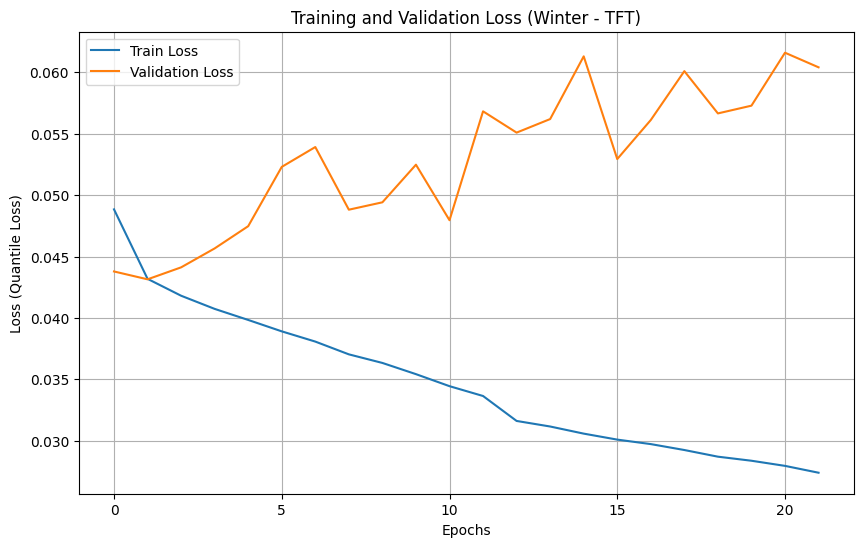


--- Final Model Evaluation on Winter Test Set ---
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step

Overall Test Set Metrics (Winter - Median Forecast):
  Mean Absolute Error (MAE): 11.8859
  Mean Squared Error (MSE):  224.6908
  Root Mean Squared Error (RMSE): 14.9897


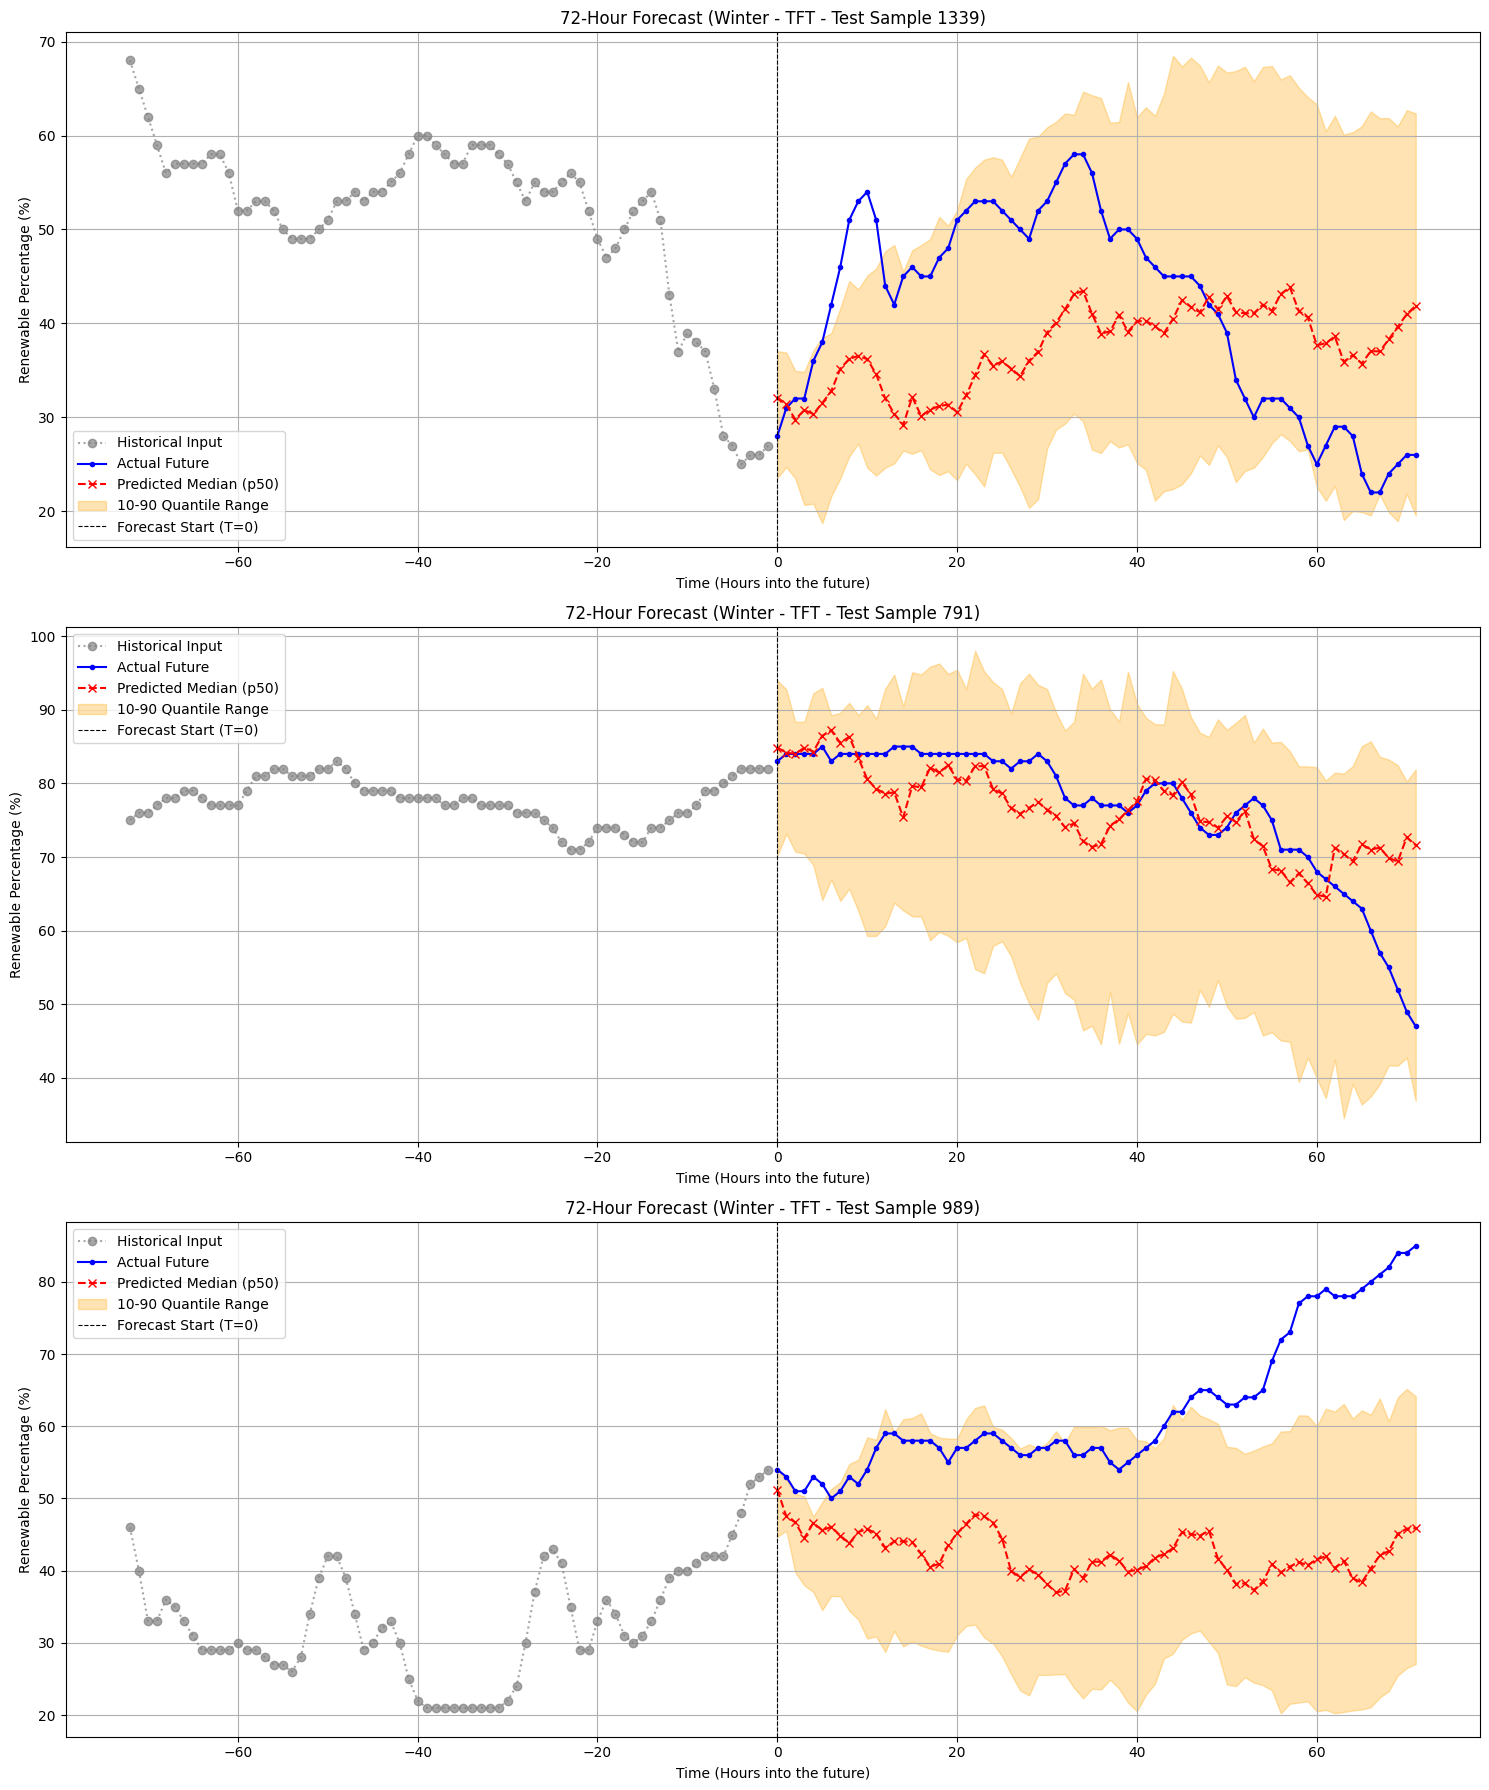

In [1]:
#!/usr/bin/env python
# coding: utf-8

# # 72-Hour Renewable Energy Forecast - Temporal Fusion Transformer (TFT)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# --- Configuration ---
config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_col': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,
        'output_length': 72,
        'hidden_dim': 32,
        'num_heads': 4,
        'num_encoder_layers': 1,
        'dropout_rate': 0.2,
        'quantiles': [0.1, 0.5, 0.9]
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'early_stopping_patience': 20,
        'lr_reduction': 0.5,
        'patience_lr': 10,
        'min_learning_rate': 1e-5
    }
}

# --- Seasonal Parameters (Winter) ---
SEASON = 'Winter'
MONTHS = [10, 11, 12, 1, 2, 3]
DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years_{SEASON.lower()}.csv"


# --- Data Handling and Feature Engineering ---

def create_time_features(df):
    """Adds time-based features to the dataframe."""
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    return df

def cyclical_encode(data, col, max_val):
    """Encodes a column cyclically."""
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

def load_and_prepare_data(file_path, target_col):
    """Loads data, performs feature engineering, and prepares it for the model."""
    print(f"Loading and preparing {SEASON} data from: {file_path}")
    # Create a dummy file if it doesn't exist for demonstration purposes
    if not os.path.exists(file_path):
        print(f"Warning: Data file '{file_path}' not found. Creating a dummy file for demonstration.")
        date_rng = pd.date_range(start='2018-01-01', end='2023-01-01', freq='H')
        dummy_data = pd.DataFrame(date_rng, columns=['date'])
        dummy_data.set_index('date', inplace=True)
        dummy_data[target_col] = np.random.rand(len(dummy_data)) * 50 + 25
        dummy_data.to_csv(file_path)
        
    try:
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data = data.rename(columns={data.columns[0]: target_col})
    except FileNotFoundError:
        print(f"CRITICAL: Data file not found at '{os.path.abspath(file_path)}'.")
        return None

    data = create_time_features(data)
    data = cyclical_encode(data, 'hour', 23.0)
    data = cyclical_encode(data, 'day_of_year', 365.0)
    
    feature_cols = [
        target_col,
        'hour_sin', 'hour_cos',
        'day_of_year_sin', 'day_of_year_cos'
    ]
    temp_data = data[feature_cols + ['hour', 'day_of_year']]
    data = temp_data.drop(columns=['hour', 'day_of_year'], errors='ignore')
    
    print("Feature engineering complete.")
    return data

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    """Splits the data into training, validation, and test sets."""
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    return data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]

def fit_scaler(train_data):
    """Fits a MinMaxScaler to the training data."""
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

def create_sequences(data_x, data_y, input_length, output_length):
    """Creates input-output sequences for the time series model."""
    x_list, y_list = [], []
    for i in range(len(data_x) - input_length - output_length + 1):
        x_list.append(data_x[i : i + input_length, :])
        y_list.append(data_y[i + input_length : i + input_length + output_length])
    return np.array(x_list), np.array(y_list)


# --- TFT Model Components ---

# FIX: Added a build() method to create sub-layers at the correct time, resolving the UserWarning.
class GatedLinearUnit(layers.Layer):
    """Gated Linear Unit activation function."""
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        """Create the dense layers here, which is the Keras-recommended practice."""
        self.linear = layers.Dense(self.units)
        self.sigmoid = layers.Dense(self.units, activation="sigmoid")
        super(GatedLinearUnit, self).build(input_shape)

    def call(self, x):
        return self.linear(x) * self.sigmoid(x)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super(GatedLinearUnit, self).get_config()
        config.update({"units": self.units})
        return config

class GatedResidualNetwork(layers.Layer):
    """Gated Residual Network component."""
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.project_input = None # Will be created in build if needed

    def build(self, input_shape):
        # Create a projection layer only if the input dimension doesn't match the GRN's units
        if input_shape[-1] != self.units:
            self.project_input = layers.Dense(self.units, name='grn_input_projection')
        
        # Create the main path layers
        self.elu_dense = layers.Dense(self.units, activation="elu", name='grn_elu_dense')
        self.linear_dense = layers.Dense(self.units, name='grn_linear_dense')
        self.dropout = layers.Dropout(self.dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(self.units)
        self.layer_norm = layers.LayerNormalization()
        super(GatedResidualNetwork, self).build(input_shape)

    def call(self, x):
        inputs = x
        # Project input if necessary
        if self.project_input is not None:
            inputs = self.project_input(inputs)
        
        # Main path
        y = self.elu_dense(x)
        y = self.linear_dense(y)
        y = self.dropout(y)
        
        # Gating and residual connection
        gated_output = self.gated_linear_unit(y)
        return self.layer_norm(inputs + gated_output)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super(GatedResidualNetwork, self).get_config()
        config.update({
            "units": self.units,
            "dropout_rate": self.dropout_rate
        })
        return config

class VariableSelectionNetwork(layers.Layer):
    """Variable Selection Network to weigh the importance of input features."""
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelectionNetwork, self).__init__(**kwargs)
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.grns = [GatedResidualNetwork(self.units, self.dropout_rate) for _ in range(self.num_features)]
        self.softmax = layers.Dense(units=self.num_features, activation="softmax")
        super(VariableSelectionNetwork, self).build(input_shape)

    def call(self, x):
        vsn_outputs = [grn(tf.expand_dims(x[:, :, i], -1)) for i, grn in enumerate(self.grns)]
        vsn_outputs = tf.concat(vsn_outputs, axis=-1)
        return self.softmax(vsn_outputs)


def build_tft_model(input_dim, hidden_dim, num_heads, num_encoder_layers, output_length, quantiles):
    """Builds the Temporal Fusion Transformer model."""
    inputs = layers.Input(shape=(config['model_params']['input_length'], input_dim))
    
    # Feature projection
    x = layers.TimeDistributed(GatedLinearUnit(hidden_dim))(inputs)
    x = layers.TimeDistributed(GatedResidualNetwork(hidden_dim, config['model_params']['dropout_rate']))(x)
    
    # Self-attention encoder
    for _ in range(num_encoder_layers):
        y = GatedResidualNetwork(hidden_dim, config['model_params']['dropout_rate'])(x)
        attn_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=config['model_params']['dropout_rate'])
        attn_output = attn_layer(y, y, y)
        x = layers.LayerNormalization()(x + attn_output)

    # Final processing before output layer
    x = layers.TimeDistributed(GatedLinearUnit(hidden_dim))(x)
    x = layers.Flatten()(x)
    
    # Output layer for quantiles
    output = layers.Dense(output_length * len(quantiles))(x)
    output = layers.Reshape((output_length, len(quantiles)))(output)

    return Model(inputs=inputs, outputs=output)

class QuantileLoss(tf.keras.losses.Loss):
    """Custom loss function for quantile regression."""
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = tf.constant(quantiles, dtype=tf.float32)
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_true = tf.expand_dims(y_true, axis=-1)
        error = y_true - y_pred
        loss = tf.reduce_mean(tf.maximum(self.quantiles * error, (self.quantiles - 1) * error), axis=-1)
        return loss


# --- Plotting & Evaluation Utility Functions ---
def plot_training_history(history, season):
    """Plots and saves the training and validation loss."""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Training and Validation Loss ({season} - TFT)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Quantile Loss)")
    plt.legend()
    plt.grid(True)
    # plt.savefig(f"training_loss_plot_{season.lower()}_tft.png") # Disabled saving
    # plt.close() # Disabled closing
    plt.show() # Added to display the plot

def plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3):
    """Selects random test samples and plots the forecast against the actual values."""
    LOOK_BACK = config['model_params']['input_length']
    FORECAST_HORIZON = config['model_params']['output_length']
    num_features = X_test.shape[2]
    if len(X_test) == 0: return

    num_plots = min(num_plots, len(X_test))
    plt.figure(figsize=(15, 6 * num_plots))
    for i in range(num_plots):
        sample_idx_plot = np.random.randint(0, len(X_test))
        y_pred_scaled_sample = model.predict(X_test[sample_idx_plot:sample_idx_plot+1], verbose=0)[0]
        
        y_pred_inversed_quantiles = []
        for j in range(y_pred_scaled_sample.shape[1]):
            dummy_pred = np.zeros((FORECAST_HORIZON, num_features))
            dummy_pred[:, target_col_index] = y_pred_scaled_sample[:, j]
            y_pred_inversed_plot = scaler.inverse_transform(dummy_pred)[:, target_col_index]
            y_pred_inversed_quantiles.append(y_pred_inversed_plot)
        
        dummy_true = np.zeros((FORECAST_HORIZON, num_features))
        dummy_true[:, target_col_index] = y_test[sample_idx_plot]
        y_true_inversed_plot = scaler.inverse_transform(dummy_true)[:, target_col_index]

        historical_input_inversed_plot = scaler.inverse_transform(X_test[sample_idx_plot])[:, target_col_index]
        
        time_axis_input_plot = np.arange(-LOOK_BACK, 0)
        time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
        
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(time_axis_input_plot, historical_input_inversed_plot, label='Historical Input', marker='o', linestyle=':', color='gray', alpha=0.7)
        plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
        plt.plot(time_axis_output_plot, y_pred_inversed_quantiles[1], label='Predicted Median (p50)', marker='x', linestyle='--', color='red')
        plt.fill_between(time_axis_output_plot, y_pred_inversed_quantiles[0], y_pred_inversed_quantiles[2], color='orange', alpha=0.3, label='10-90 Quantile Range')
        
        plt.title(f'{FORECAST_HORIZON}-Hour Forecast ({SEASON} - TFT - Test Sample {sample_idx_plot})')
        plt.xlabel('Time (Hours into the future)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"forecast_examples_{SEASON.lower()}_tft.png") # Disabled saving
    # plt.close() # Disabled closing
    plt.show() # Added to display the plot


# --- Main Execution ---
if __name__ == "__main__":
    full_feature_data = load_and_prepare_data(DATA_FILENAME, config['data_params']['target_col'])
    if full_feature_data is not None:
        target_col_index = full_feature_data.columns.get_loc(config['data_params']['target_col'])
        config['model_params']['n_features'] = full_feature_data.shape[1]
        
        train_df, val_df, test_df = train_val_test_split(full_feature_data)
        
        scaler = fit_scaler(train_df)
        train_scaled = scaler.transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        X_train, y_train = create_sequences(train_scaled, train_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_val, y_val = create_sequences(val_scaled, val_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        X_test, y_test = create_sequences(test_scaled, test_scaled[:, target_col_index], config['model_params']['input_length'], config['model_params']['output_length'])
        
        print("Datasets created.")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        
        model = build_tft_model(
            input_dim=config['model_params']['n_features'],
            hidden_dim=config['model_params']['hidden_dim'],
            num_heads=config['model_params']['num_heads'],
            num_encoder_layers=config['model_params']['num_encoder_layers'],
            output_length=config['model_params']['output_length'],
            quantiles=config['model_params']['quantiles']
        )
        
        optimizer = keras.optimizers.Adam(learning_rate=config['training_params']['initial_learning_rate'])
        model.compile(optimizer=optimizer, loss=QuantileLoss(config['model_params']['quantiles']))
        model.summary()

        callbacks = [
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=config['training_params']['lr_reduction'], patience=config['training_params']['patience_lr'], min_lr=config['training_params']['min_learning_rate']),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['training_params']['early_stopping_patience'], restore_best_weights=True)
        ]
        
        print(f"\n--- Starting TFT {SEASON} Model Training ---\n")
        history = model.fit(X_train, y_train,
                            epochs=config['training_params']['num_epochs'],
                            batch_size=config['training_params']['batch_size'],
                            validation_data=(X_val, y_val),
                            callbacks=callbacks,
                            verbose=1)
        
        plot_training_history(history, SEASON)
        
        if X_test.shape[0] > 0 and y_test.shape[0] > 0:
            print(f"\n--- Final Model Evaluation on {SEASON} Test Set ---")
            y_pred_scaled = model.predict(X_test)
            
            median_pred_scaled = y_pred_scaled[:, :, 1]
            
            num_test_samples = y_test.shape[0] * y_test.shape[1]
            num_features = X_test.shape[2]
            
            y_test_dummy = np.zeros((num_test_samples, num_features)); y_test_dummy[:, target_col_index] = y_test.flatten()
            y_test_inversed = scaler.inverse_transform(y_test_dummy)[:, target_col_index]
            
            y_pred_dummy = np.zeros((num_test_samples, num_features)); y_pred_dummy[:, target_col_index] = median_pred_scaled.flatten()
            y_pred_inversed = scaler.inverse_transform(y_pred_dummy)[:, target_col_index]
            
            mae_overall = mean_absolute_error(y_test_inversed, y_pred_inversed)
            mse_overall = mean_squared_error(y_test_inversed, y_pred_inversed)
            rmse_overall = np.sqrt(mse_overall)
            
            print(f"\nOverall Test Set Metrics ({SEASON} - Median Forecast):"); print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}"); print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}"); print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")
            
            plot_test_forecasts(model, X_test, y_test, scaler, target_col_index, num_plots=3)
        
    else:
        print("Data could not be loaded. Halting execution.")


# next I'll use:

**Informer**

**Autoformer**

**PatchTST**

**Mamba (TimesMamba)**

**DLinear**

**CarbonCast**

**EnsembleCI**